# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import time
import random

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
category = 'Induk anak huruf di samping'

train_dir = f"../dataset/preprocessed/{category}/train"
val_dir = f"../dataset/preprocessed/{category}/val"
test_dir = f"../dataset/preprocessed/{category}/test"

IMG_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

print('\nTrain Data:')
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

print('\nValidation Data:')
generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

print('\nTesting Data:')
generator_test = datagen_test.flow_from_directory(directory=test_dir, 
                                                  target_size=IMG_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=False)


Train Data:
Found 1475 images belonging to 59 classes.

Validation Data:
Found 413 images belonging to 59 classes.

Testing Data:
Found 236 images belonging to 59 classes.


In [3]:
classes_train = generator_train.classes
classes_val = generator_val.classes
classes_test = generator_test.classes

In [4]:
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
print('Classes Names:', class_names)

Classes Names: ['AH', 'AI', 'B', 'BAH', 'BAI', 'C', 'CAH', 'CAI', 'D', 'DAH', 'DAI', 'G', 'GAH', 'GAI', 'GH', 'GHAH', 'GHAI', 'H', 'HAH', 'HAI', 'J', 'JAH', 'JAI', 'K', 'KAH', 'KAI', 'L', 'LAH', 'LAI', 'M', 'MAH', 'MAI', 'N', 'NAH', 'NAI', 'NG', 'NGAH', 'NGAI', 'NY', 'NYAH', 'NYAI', 'P', 'PAH', 'PAI', 'R', 'RAH', 'RAI', 'S', 'SAH', 'SAI', 'T', 'TAH', 'TAI', 'W', 'WAH', 'WAI', 'Y', 'YAH', 'YAI']


# Helper Functions

In [5]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [6]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [9]:
def plot_history(history):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.grid()
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Accuracy', 'Validation Accuracy'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Loss', 'Validation Loss'])

    plt.show()

In [10]:
def plot_confusion_matrix(actual_classes, predicted_classes):
    # Hitung confusion matrix antara label kelas asli dan label kelas prediksi
    conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    # Plot confusion matrix dalam bentuk heatmap
    plt.figure(figsize=(25, 15))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Hitung classification report
    report = classification_report(actual_classes, predicted_classes, target_names=class_names)

    # Tampilkan classification report
    print("Classification Report:")
    print(report)

In [11]:
def example_success(actual_classes, predicted_classes):
    
    # Boolean array whether the predicted class is incorrect.
    correct = (predicted_classes == actual_classes)

    # Get the file-paths for images that were correctly classified.
    image_paths = np.array(image_paths_test)[correct]

    # Randomly .
    i = random.randint(0, len(image_paths)-9)
    j = i + 9

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[i:j])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[correct] 

    # Get the true classes for those images.
    cls_true = actual_classes[correct]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[i:j],
                cls_pred=class_pred[i:j])

In [12]:
def example_errors(actual_classes, predicted_classes):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (predicted_classes != actual_classes)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[incorrect] 

    # Get the true classes for those images.
    cls_true = actual_classes[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=class_pred[0:9])
    
    predict_paths = []
    random.seed(42)
    for cls in class_pred:
        class_dir = os.path.join(test_dir, class_names[cls])
        new_path = class_dir.replace("/test", "/train")
        predict_path = random.choice([os.path.join(new_path, file) for file in os.listdir(new_path) if file.endswith('.png') and 'aug' not in file])
        predict_paths.append(predict_path)
    predict_img= load_images(predict_paths)
    print(len(predict_img), len(class_pred))

    plot_images(images=predict_img, cls_true=class_pred, smooth=True)

In [13]:
def grid_search_results(gs):
    print(f"Fitting {gs.n_splits_} folds for each of {len(gs.cv_results_['params'])} candidates, totalling {len(gs.cv_results_['params']) * gs.n_splits_} fits")
    for i, param in enumerate(gs.cv_results_['params']):
        print(f"Parameters: {param}")
        for j in range(gs.n_splits_):
            accuracy = gs.cv_results_[f'split{j}_test_accuracy'][i]
            neg_log_loss = gs.cv_results_[f'split{j}_test_neg_log_loss'][i]
            print(f"[CV {j+1}/{gs.n_splits_}] accuracy: (test={accuracy:.3f}) log_loss: (test={neg_log_loss*-1:.3f})")
        print()
    print('Best Parameter:', gs.best_params_, 'with average accuracy score:', gs.best_score_.round(4))

In [14]:
import csv

csv_file = f"../benchmark_result/{category}/results.csv"

def read_existing_results(csv_file):
    results = {}
    if os.path.isfile(csv_file):
        with open(csv_file, mode='r', newline='') as file:
            reader = csv.reader(file, delimiter=';')
            next(reader)  # Skip the header
            for row in reader:
                model_name = row[0]
                results[model_name] = [float(row[1]), float(row[2]), float(row[3]), float(row[4]), float(row[5])]
    return results

def save_results(accuracy_results):
    # Read existing results
    existing_results = read_existing_results(csv_file)

    # Update existing results with new data
    existing_results.update(accuracy_results)

    # Write the updated results to the CSV file
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        header = ['Model Name', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Training Time', 'Predicting Time']
        writer.writerow(header)
        for model_name, results in existing_results.items():
            writer.writerow([model_name] + results)

    print(f'Data has been saved to {csv_file}')

# Plot Sample of Images

In [15]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_val = path_join(val_dir, generator_val.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

train_images = load_images(image_paths_train)
val_images = load_images(image_paths_val)
test_images = load_images(image_paths_test)

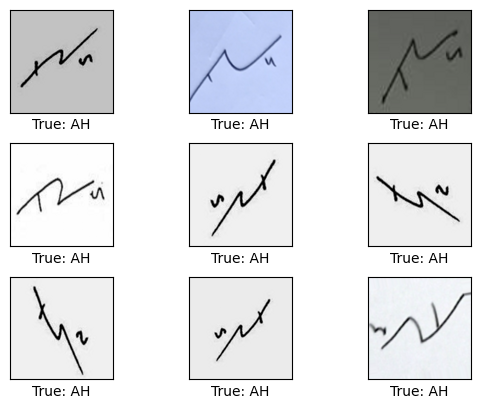

In [16]:
# Plot the images and labels using our helper-function above.
plot_images(images=train_images, cls_true=classes_train, smooth=True)

# Modeling Experiment

In [17]:
accuracy_results  = {}

## VGG16

In [18]:
vgg16_pretrained = VGG16(include_top=False, 
                         input_shape=(224, 224, 3), 
                         weights='imagenet')

vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Build a Model

In [19]:
m = vgg16_pretrained.output
m = Flatten()(m)
m = Dense(4096, activation='relu', name='fc1')(m)
m = Dense(4096, activation='relu', name='fc2')(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

vgg16_m = Model(inputs=vgg16_pretrained.input, outputs=predictions, name="vgg16")

vgg16_m.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
print_layer_trainable(vgg16_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	prediction


In [21]:
for layer in vgg16_m.layers:
    layer.trainable = False
    if layer.name.startswith('block5_pool'):
        break

vgg16_m.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
print_layer_trainable(vgg16_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	prediction


### Set Paramater Values

In [23]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [24]:
vgg16_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16 = vgg16_m.fit_generator(generator_train,
                                epochs=EPOCHS, 
                                steps_per_epoch=STEPS_PER_EPOCH, 
                                validation_data=generator_val, 
                                validation_steps=VALIDATION_STEPS, 
                                callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
46/46 [==============================] - 23s 358ms/step - loss: 6.2009 - categorical_accuracy: 0.0122 - val_loss: 4.0151 - val_categorical_accuracy: 0.0242 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - 12s 257ms/step - loss: 3.8247 - categorical_accuracy: 0.0420 - val_loss: 3.3348 - val_categorical_accuracy: 0.0993 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - 12s 258ms/step - loss: 3.0656 - categorical_accuracy: 0.1437 - val_loss: 2.6584 - val_categorical_accuracy: 0.1889 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - 14s 295ms/step - loss: 2.4759 - categorical_accuracy: 0.2617 - val_loss: 2.3434 - val_categorical_accuracy: 0.2809 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - 14s 292ms/step - loss: 2.1315 - categorical_accuracy: 0.3498 - val_loss: 1.8507 - val_categorical_accuracy: 0.3826 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - 14s 298ms/step - loss: 1.6867 - categorical_accu

### Model Evaluation

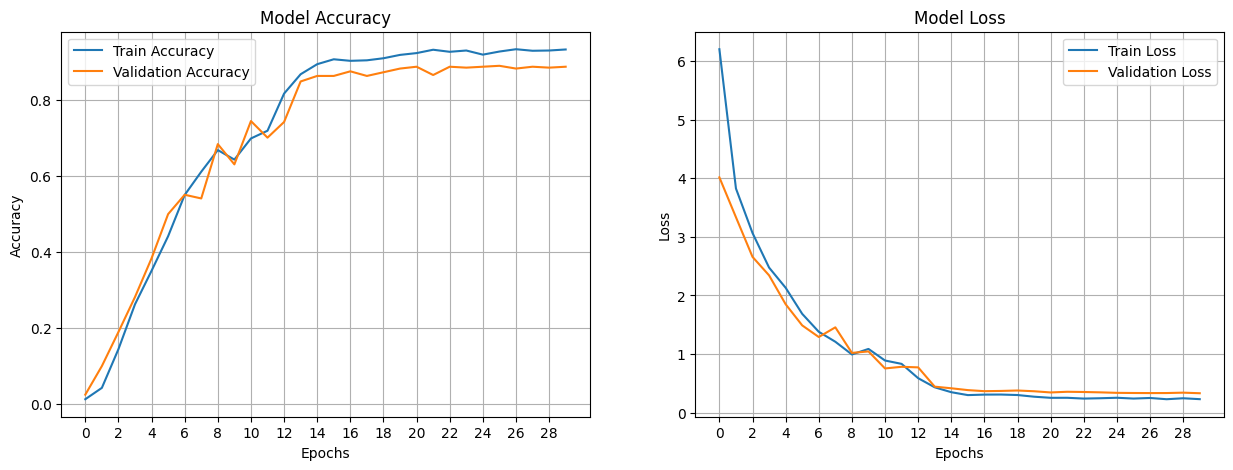

In [25]:
plot_history(h_vgg16)

In [26]:
model_name = 'vgg16_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_m= load_model(model_path)

train_loss, train_accuracy = vgg16_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.2282526195049286
Training Accuracy: 0.9383050799369812
------------------------------------------------
Validation Loss: 0.3366020619869232
Validation Accuracy: 0.8886198401451111
------------------------------------------------
Training Times: 387.0266070365906 seconds


### Prediction on Test Dataset

Predicting Times: 2.8926193714141846 seconds


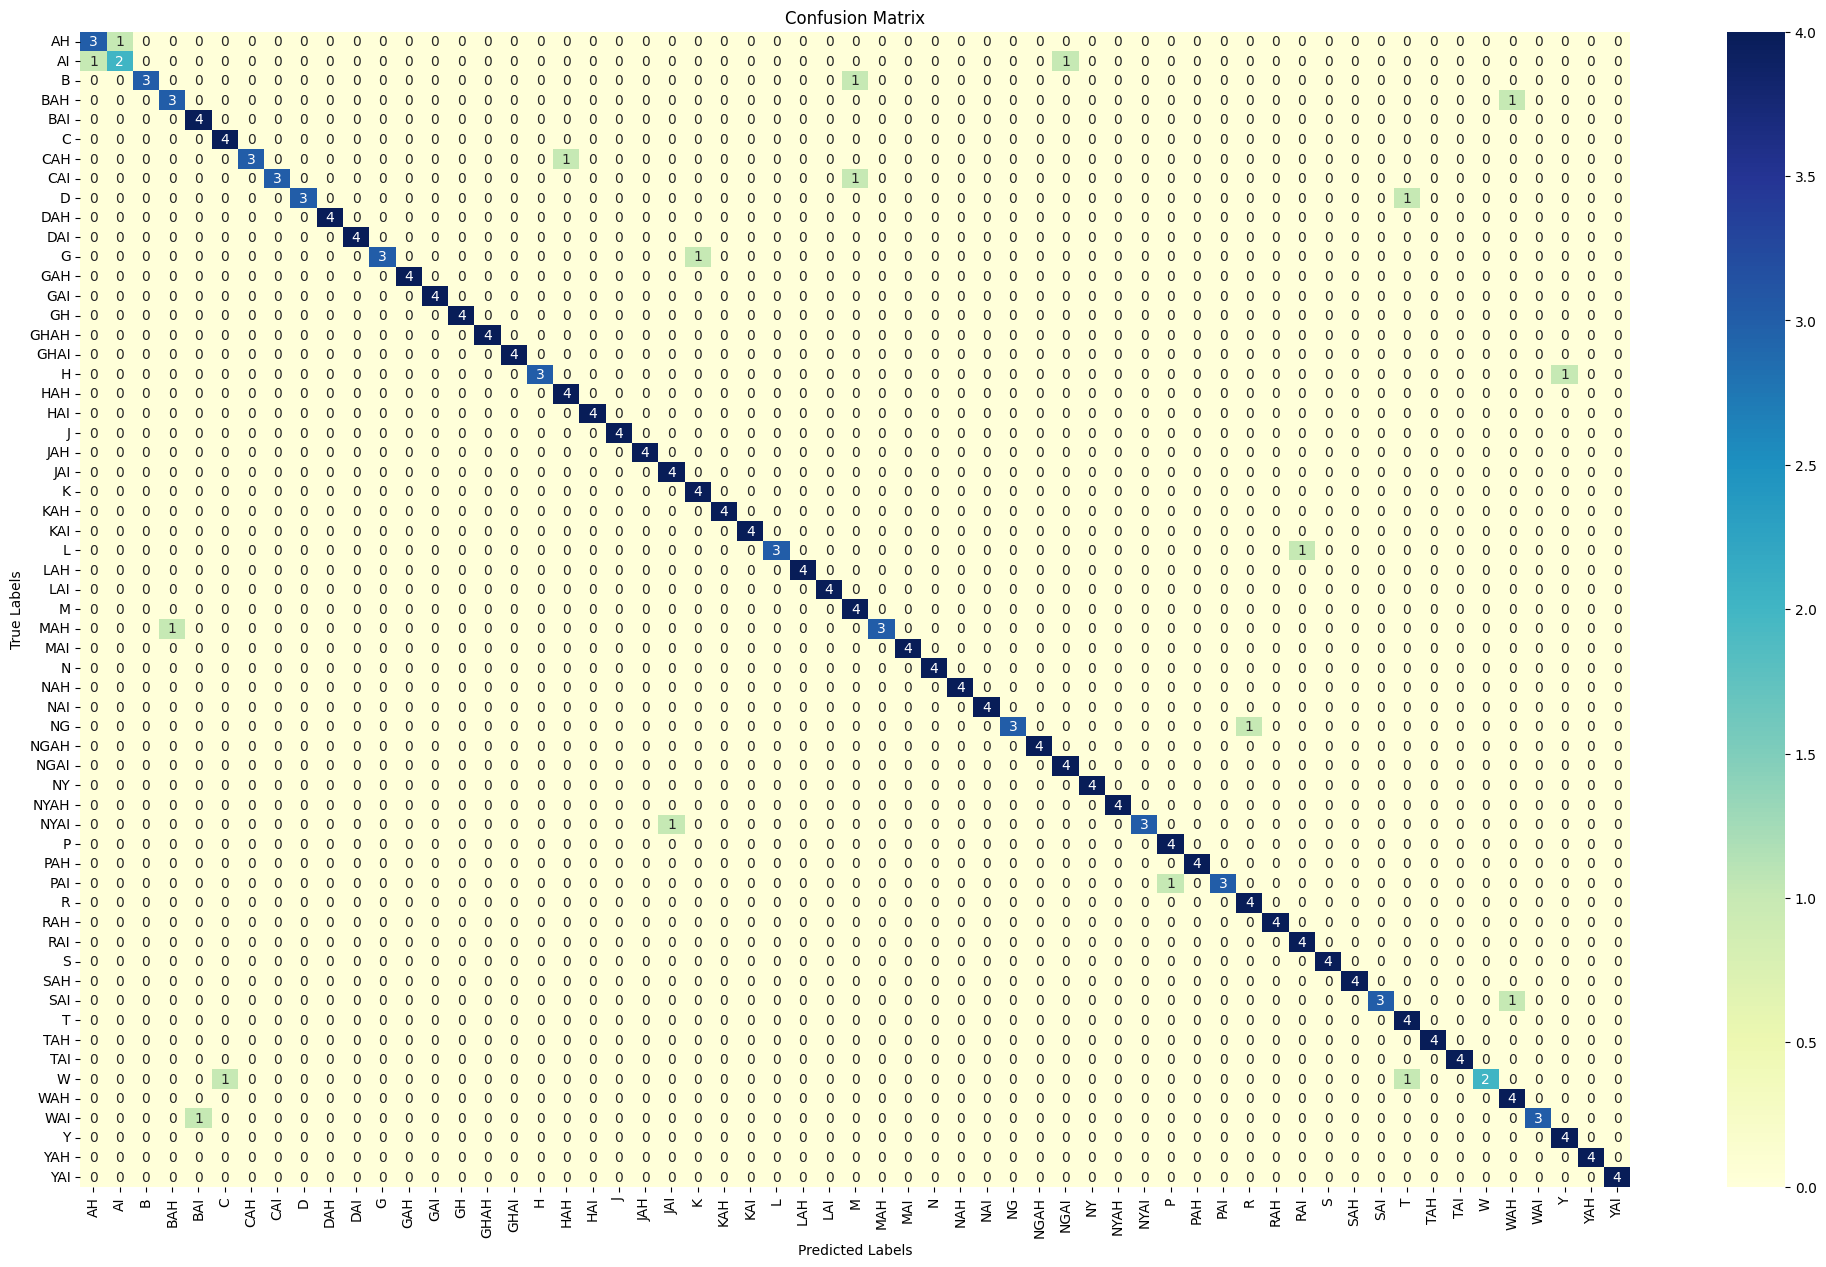

Classification Report:
              precision    recall  f1-score   support

          AH       0.75      0.75      0.75         4
          AI       0.67      0.50      0.57         4
           B       1.00      0.75      0.86         4
         BAH       0.75      0.75      0.75         4
         BAI       0.80      1.00      0.89         4
           C       0.80      1.00      0.89         4
         CAH       1.00      0.75      0.86         4
         CAI       1.00      0.75      0.86         4
           D       1.00      0.75      0.86         4
         DAH       1.00      1.00      1.00         4
         DAI       1.00      1.00      1.00         4
           G       1.00      0.75      0.86         4
         GAH       1.00      1.00      1.00         4
         GAI       1.00      1.00      1.00         4
          GH       1.00      1.00      1.00         4
        GHAH       1.00      1.00      1.00         4
        GHAI       1.00      1.00      1.00         4
    

In [27]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

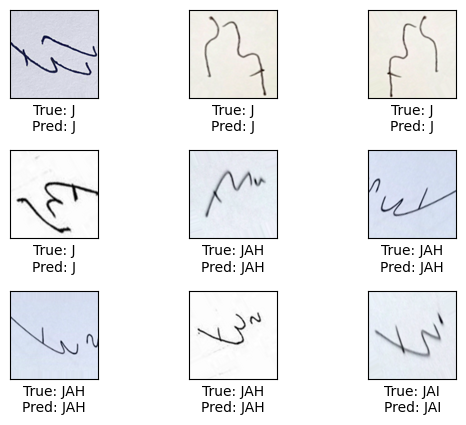

In [28]:
example_success(classes_test, predicted_classes)

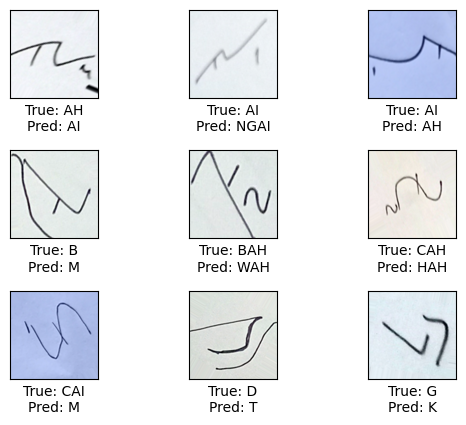

19 19


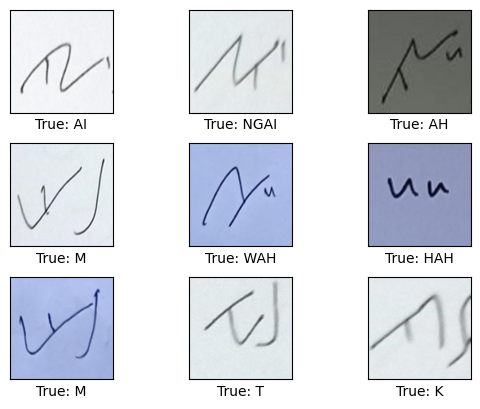

In [ ]:
example_errors(classes_test, predicted_classes)

In [30]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## VGG16 + Random Forest

### Features Extraction

In [19]:
X_train = vgg16_pretrained.predict(train_images)
X_val = vgg16_pretrained.predict(val_images)

# Flatten the features
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

y_train, y_val = classes_train, classes_val

13/13 [==============================] - 5s 403ms/step


### Training the model

In [20]:
start_time = time.time()
rf_classifier = RandomForestClassifier(random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [21]:
model_name = 'vgg16_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_rf_m = joblib.load(model_path)

In [22]:
# Predictions and evaluation on training set
train_predictions = vgg16_rf_m.predict(X_train)
train_predictions_prob = vgg16_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_rf_m.predict(X_val)
val_predictions_prob = vgg16_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.4065955578644255
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 2.923394602442165
Validation Accuracy: 0.5084745762711864
------------------------------------------------
Training Times: 20.277281284332275 seconds


### Prediction of Test Dataset

8/8 [==============================] - 3s 403ms/step
Predicting Times: 2.9917993545532227 seconds


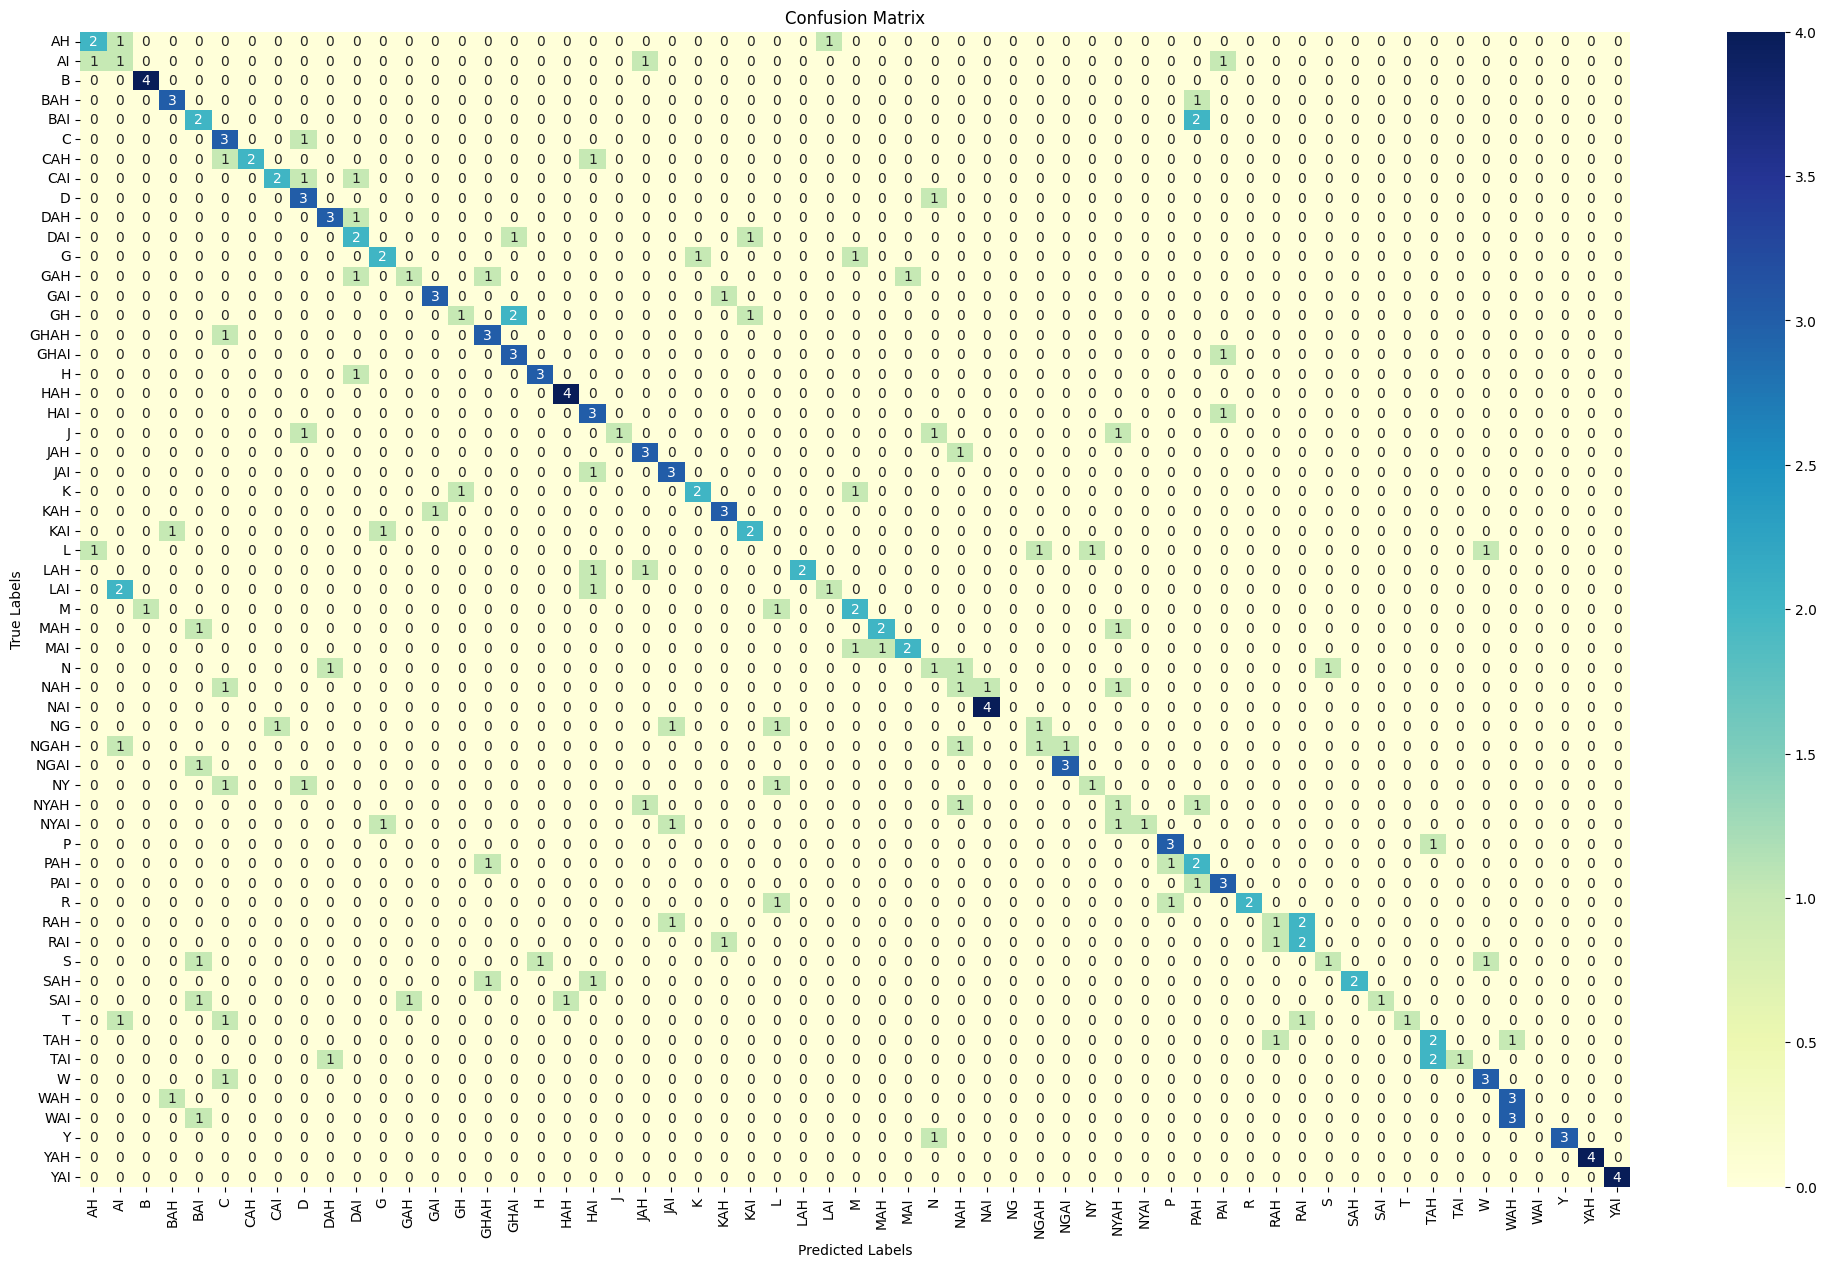

Classification Report:
              precision    recall  f1-score   support

          AH       0.50      0.50      0.50         4
          AI       0.17      0.25      0.20         4
           B       0.80      1.00      0.89         4
         BAH       0.60      0.75      0.67         4
         BAI       0.29      0.50      0.36         4
           C       0.33      0.75      0.46         4
         CAH       1.00      0.50      0.67         4
         CAI       0.67      0.50      0.57         4
           D       0.43      0.75      0.55         4
         DAH       0.60      0.75      0.67         4
         DAI       0.33      0.50      0.40         4
           G       0.50      0.50      0.50         4
         GAH       0.50      0.25      0.33         4
         GAI       0.75      0.75      0.75         4
          GH       0.50      0.25      0.33         4
        GHAH       0.50      0.75      0.60         4
        GHAI       0.50      0.75      0.60         4
    

In [23]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_pretrained.predict(test_images)
X_test = X_test.reshape(X_test.shape[0],-1)
predictions = vgg16_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

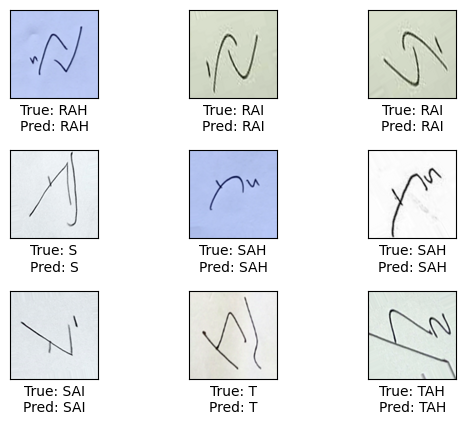

In [24]:
example_success(y_test, predictions)

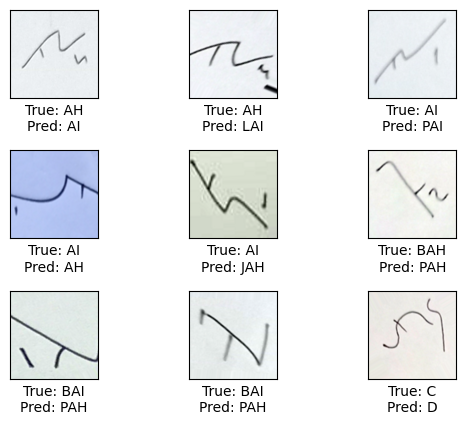

112 112


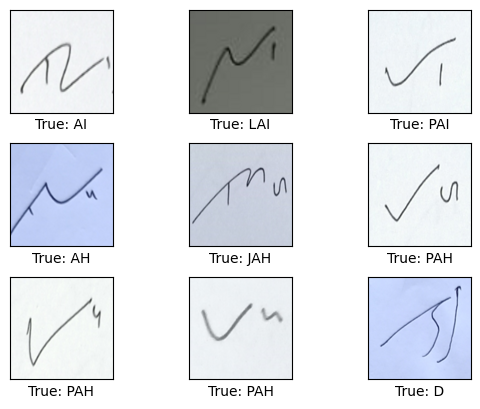

In [ ]:
example_errors(y_test, predictions)

In [26]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## VGG16 Tuning

### Build a Moodel

In [19]:
m = vgg16_pretrained.output
m = GlobalAveragePooling2D()(m)
m = BatchNormalization()(m)
m = Dense(512, activation='relu', name='fc1')(m)
m = Dropout(0.5)(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

vgg16_tuned_m = Model(inputs=vgg16_pretrained.input, outputs=predictions, name="vgg16_tuned")

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [20]:
for layer in vgg16_tuned_m.layers:
    layer.trainable = True

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [21]:
print_layer_trainable(vgg16_tuned_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


In [22]:
for layer in vgg16_tuned_m.layers:
    if layer.name.startswith('block5_conv1'):
        break
    layer.trainable = False

vgg16_tuned_m.summary()

Model: "vgg16_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       

In [23]:
print_layer_trainable(vgg16_tuned_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


### Set Parameter Values

In [24]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_tuned_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [25]:
vgg16_tuned_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16_tune = vgg16_tuned_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
46/46 [==============================] - 23s 328ms/step - loss: 3.9627 - categorical_accuracy: 0.0447 - val_loss: 25.4671 - val_categorical_accuracy: 0.0169 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - 10s 223ms/step - loss: 3.4366 - categorical_accuracy: 0.0936 - val_loss: 13.9622 - val_categorical_accuracy: 0.0169 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - 11s 234ms/step - loss: 2.9787 - categorical_accuracy: 0.1837 - val_loss: 12.2559 - val_categorical_accuracy: 0.0291 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - 10s 219ms/step - loss: 2.4716 - categorical_accuracy: 0.2861 - val_loss: 16.3863 - val_categorical_accuracy: 0.0218 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - 10s 223ms/step - loss: 1.9808 - categorical_accuracy: 0.3959 - val_loss: 6.4513 - val_categorical_accuracy: 0.0872 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - 10s 223ms/step - loss: 1.7933 - categorical_

### Model Evaluation

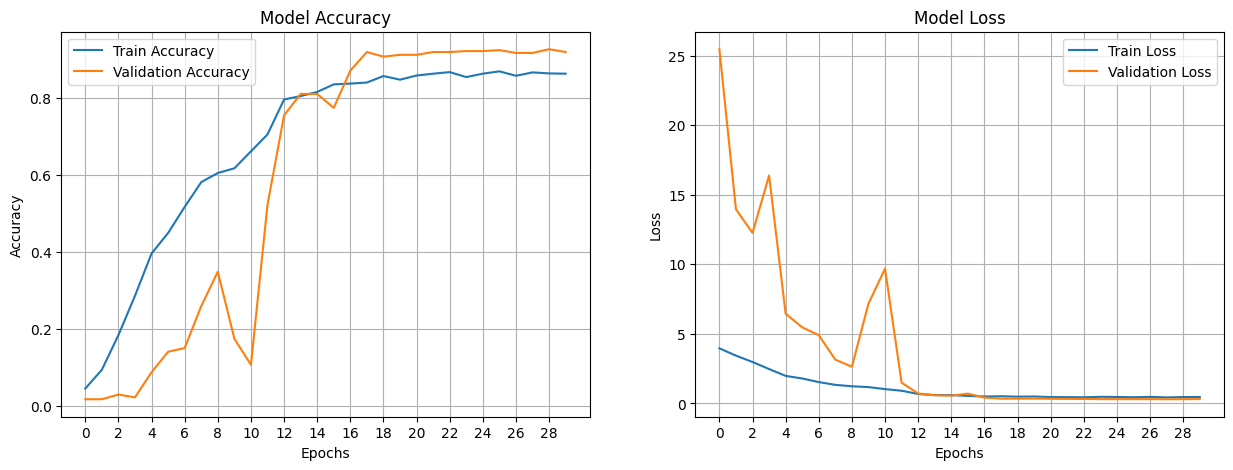

In [26]:
plot_history(h_vgg16_tune)

In [27]:
model_name = 'vgg16_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_tuned_m = load_model(model_path)

train_loss, train_accuracy = vgg16_tuned_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_tuned_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.2347506284713745
Training Accuracy: 0.9498305320739746
------------------------------------------------
Validation Loss: 0.30476030707359314
Validation Accuracy: 0.9273607730865479
------------------------------------------------
Training Times: 318.75221157073975 seconds


### Prediction of Test Dataset

Predicting Times: 2.8339035511016846 seconds


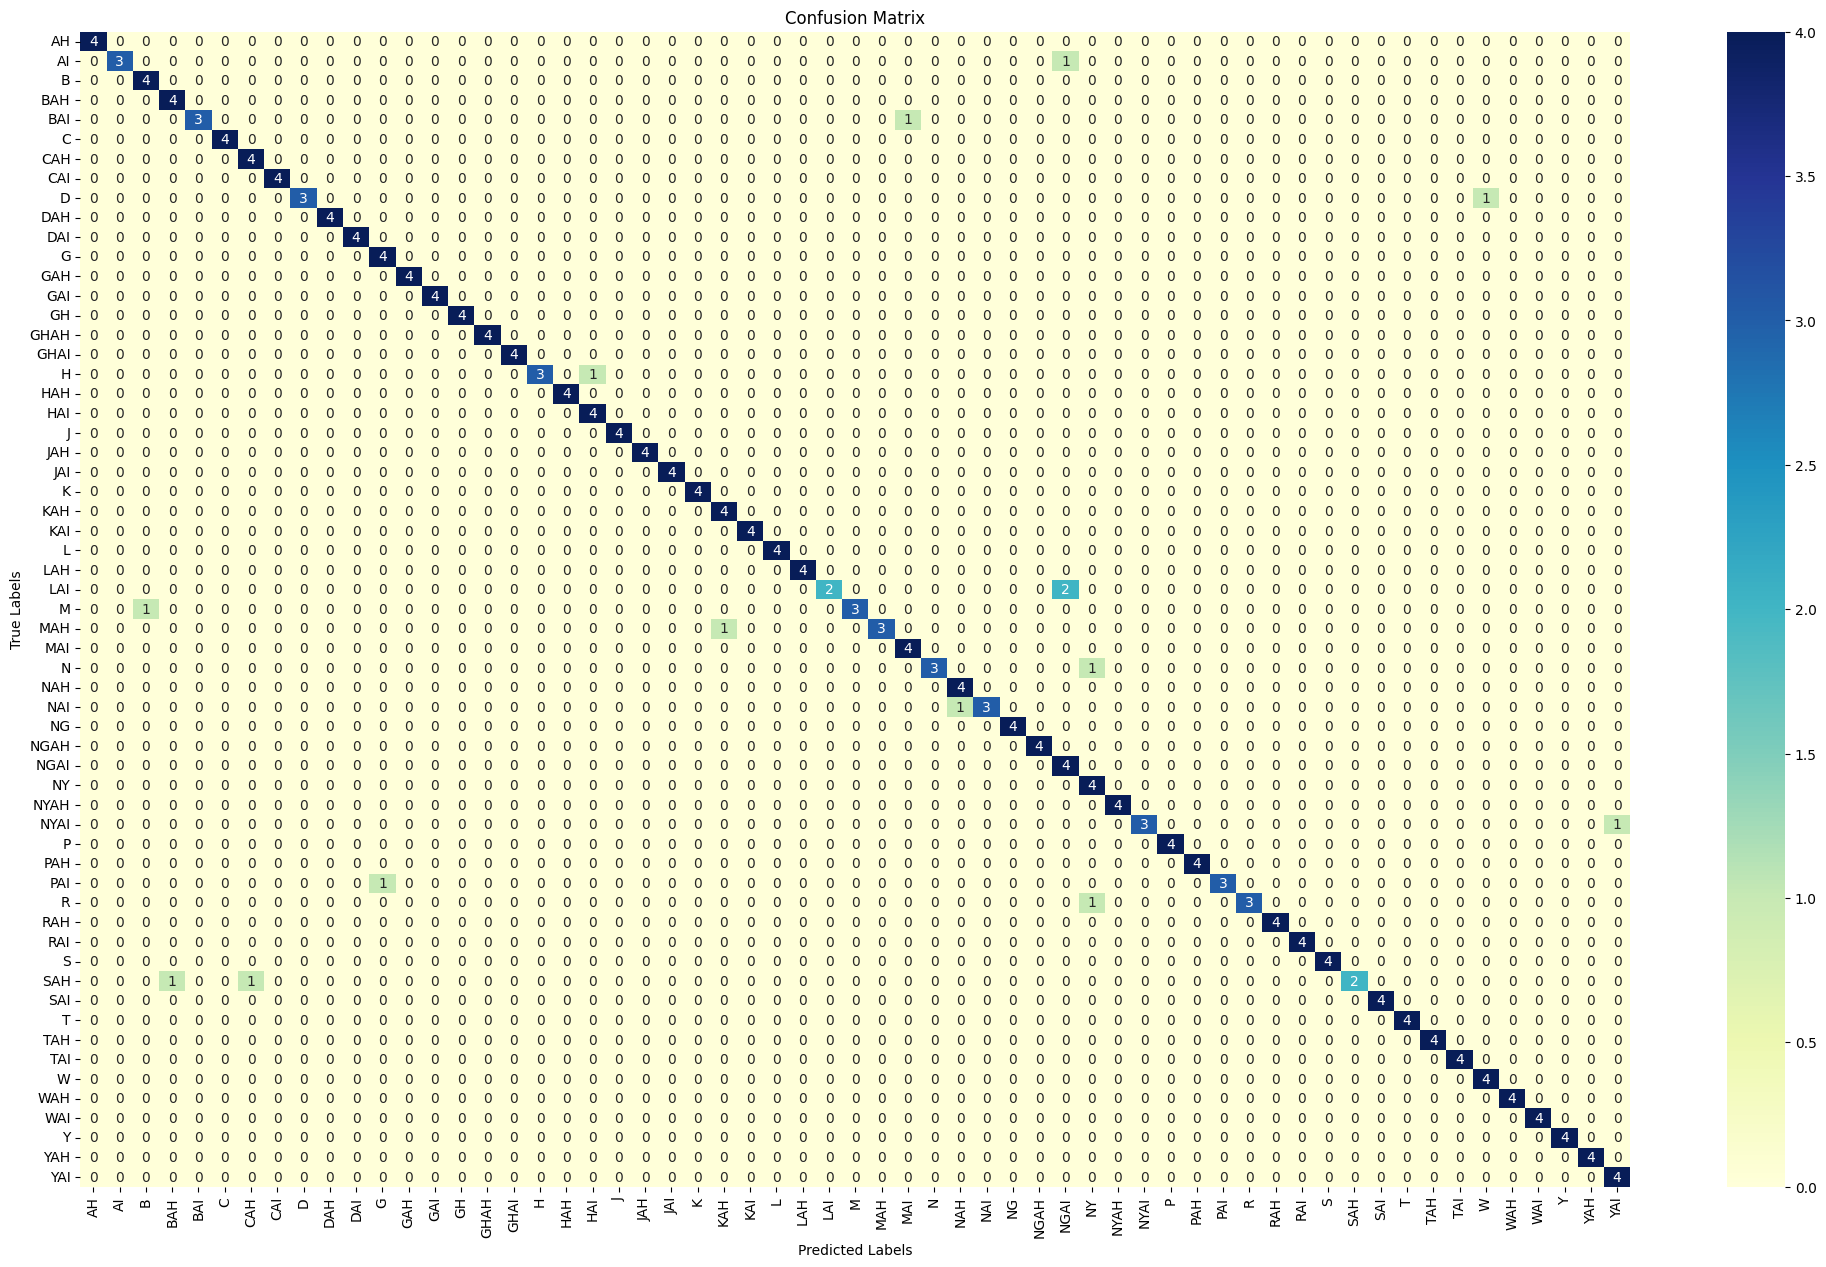

Classification Report:
              precision    recall  f1-score   support

          AH       1.00      1.00      1.00         4
          AI       1.00      0.75      0.86         4
           B       0.80      1.00      0.89         4
         BAH       0.80      1.00      0.89         4
         BAI       1.00      0.75      0.86         4
           C       1.00      1.00      1.00         4
         CAH       0.80      1.00      0.89         4
         CAI       1.00      1.00      1.00         4
           D       1.00      0.75      0.86         4
         DAH       1.00      1.00      1.00         4
         DAI       1.00      1.00      1.00         4
           G       0.80      1.00      0.89         4
         GAH       1.00      1.00      1.00         4
         GAI       1.00      1.00      1.00         4
          GH       1.00      1.00      1.00         4
        GHAH       1.00      1.00      1.00         4
        GHAI       1.00      1.00      1.00         4
    

In [28]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_tuned_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_tuned_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

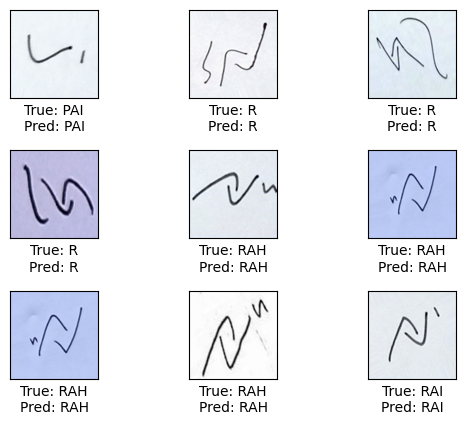

In [29]:
example_success(classes_test, predicted_classes)

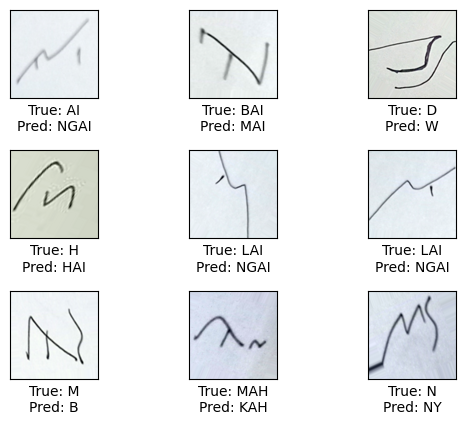

15 15


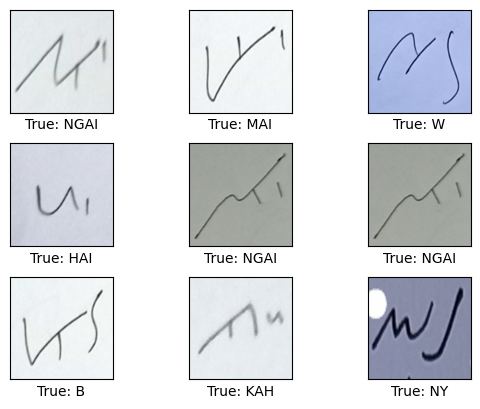

In [ ]:
example_errors(classes_test, predicted_classes)

In [31]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## VGG16 + Random Forest Tuning

### Build the Model for Features Extraction

In [46]:
vgg16_tuned_fe = vgg16_tuned_m.layers[-5]

vgg16_tuned_fe = Model(inputs=vgg16_tuned_m.input,
                    outputs=vgg16_tuned_fe.output)

for layer in vgg16_tuned_fe.layers:
    layer.trainable = False

vgg16_tuned_fe.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

 block4_conv1 (Conv2D)       (None, 28, 28, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 28, 28, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 14, 14, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 14, 14, 512)       2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0         
          

### Hyperparameter Tunning GridSearchCV

In [47]:
X_train = vgg16_tuned_fe.predict(train_images)
X_val = vgg16_tuned_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

13/13 [==============================] - 1s 85ms/step


In [48]:
X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

params = {
    'n_estimators' : [100, 200, 300, 400]
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'])

In [49]:
grid_search_results(gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.937) log_loss: (test=0.693)
[CV 2/5] accuracy: (test=0.934) log_loss: (test=0.761)
[CV 3/5] accuracy: (test=0.955) log_loss: (test=0.673)
[CV 4/5] accuracy: (test=0.984) log_loss: (test=0.570)
[CV 5/5] accuracy: (test=0.947) log_loss: (test=0.651)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.955) log_loss: (test=0.685)
[CV 2/5] accuracy: (test=0.942) log_loss: (test=0.757)
[CV 3/5] accuracy: (test=0.952) log_loss: (test=0.681)
[CV 4/5] accuracy: (test=0.981) log_loss: (test=0.570)
[CV 5/5] accuracy: (test=0.950) log_loss: (test=0.654)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.958) log_loss: (test=0.685)
[CV 2/5] accuracy: (test=0.942) log_loss: (test=0.755)
[CV 3/5] accuracy: (test=0.952) log_loss: (test=0.681)
[CV 4/5] accuracy: (test=0.981) log_loss: (test=0.568)
[CV 5/5] accuracy: (test=0.952) log_loss: (test=0.658)

Parameters

### Training the model

In [50]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [51]:
model_name = 'vgg16_rf_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_rf_tuned_m = joblib.load(model_path)

In [52]:
# Predictions and evaluation on training set
train_predictions = vgg16_rf_tuned_m.predict(X_train)
train_predictions_prob = vgg16_rf_tuned_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_rf_tuned_m.predict(X_val)
val_predictions_prob = vgg16_rf_tuned_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.17422998406972107
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.6717791914523223
Validation Accuracy: 0.9515738498789347
------------------------------------------------
Training Times: 5.041079521179199 seconds


### Prediction of Test Dataset

8/8 [==============================] - 1s 96ms/step
Predicting Times: 0.8594076633453369 seconds


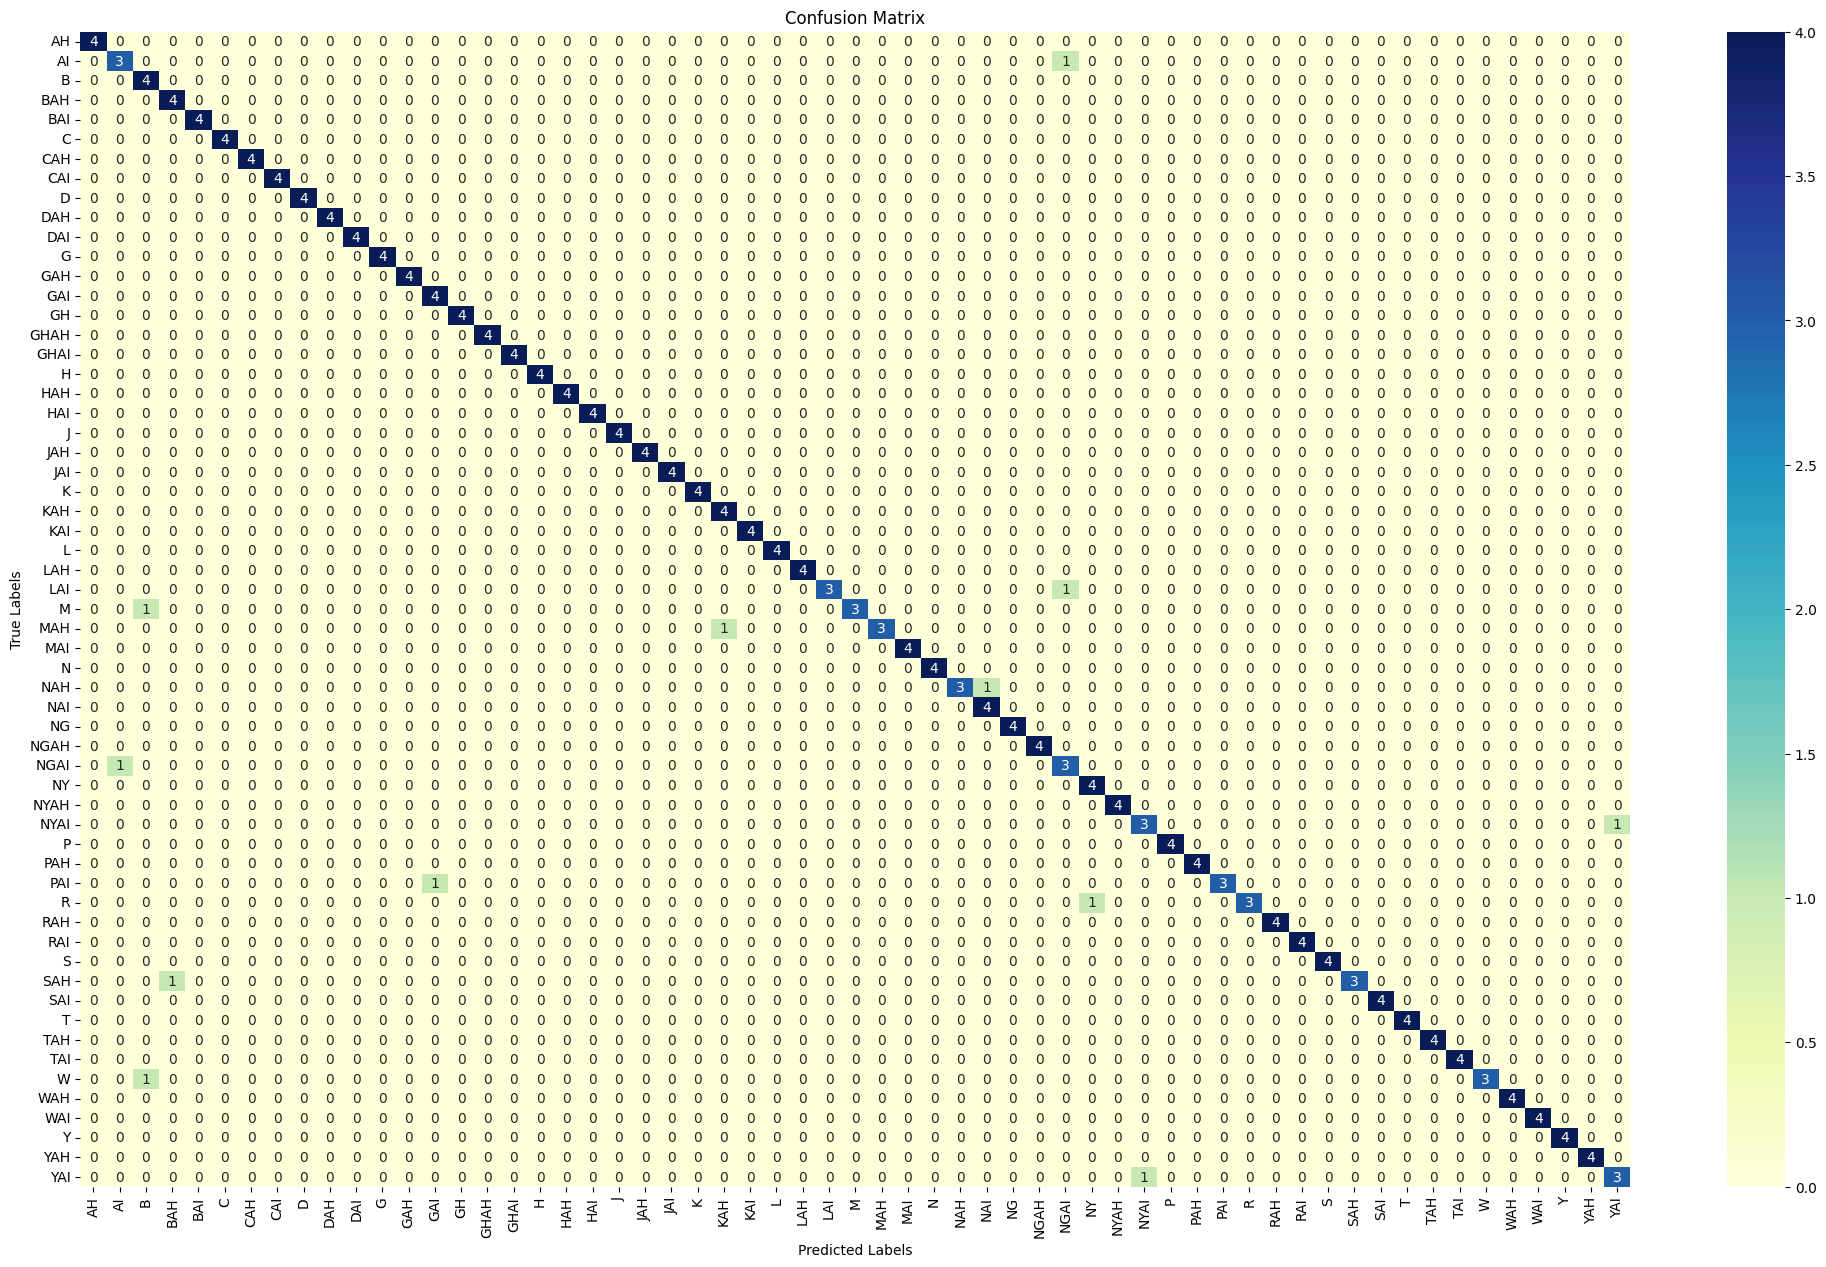

Classification Report:
              precision    recall  f1-score   support

          AH       1.00      1.00      1.00         4
          AI       0.75      0.75      0.75         4
           B       0.67      1.00      0.80         4
         BAH       0.80      1.00      0.89         4
         BAI       1.00      1.00      1.00         4
           C       1.00      1.00      1.00         4
         CAH       1.00      1.00      1.00         4
         CAI       1.00      1.00      1.00         4
           D       1.00      1.00      1.00         4
         DAH       1.00      1.00      1.00         4
         DAI       1.00      1.00      1.00         4
           G       1.00      1.00      1.00         4
         GAH       1.00      1.00      1.00         4
         GAI       0.80      1.00      0.89         4
          GH       1.00      1.00      1.00         4
        GHAH       1.00      1.00      1.00         4
        GHAI       1.00      1.00      1.00         4
    

In [53]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_tuned_fe.predict(test_images)
predictions = vgg16_rf_tuned_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

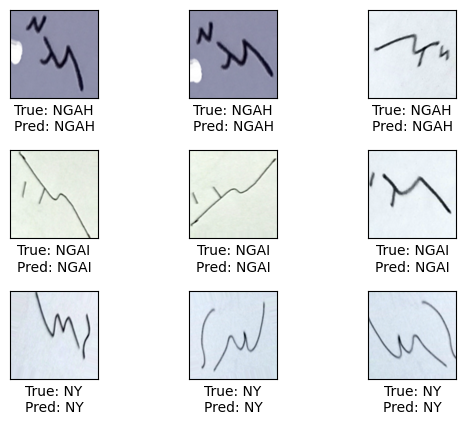

In [54]:
example_success(y_test, predictions)

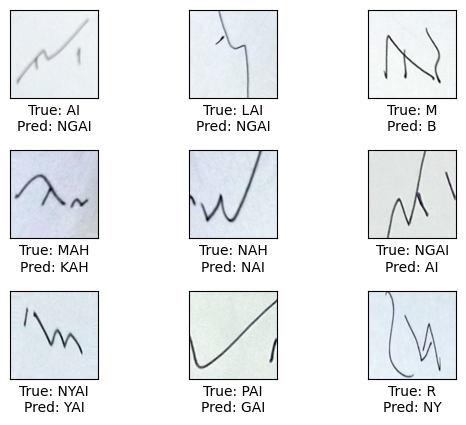

12 12


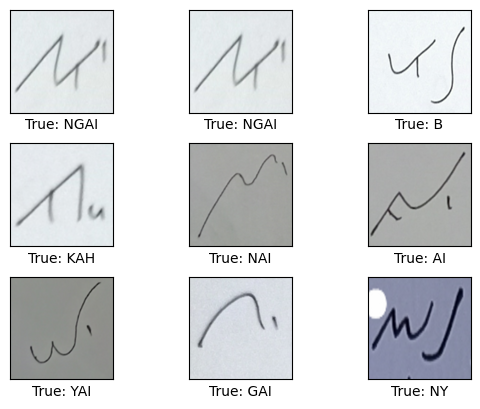

In [ ]:
example_errors(y_test, predictions)

In [56]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## ResNet50V2

In [18]:
resnet50_pretrained = ResNet50V2(include_top=False, 
                                 input_shape=(224, 224, 3),
                                 weights='imagenet')

resnet50_pretrained.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Build a Model

In [19]:
m = resnet50_pretrained.output
m = GlobalAveragePooling2D()(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

resnet50_m = Model(inputs=resnet50_pretrained.input, outputs=predictions, name="resnet50")

resnet50_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_out (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 56, 56, 256)  1024       ['conv2_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)  

In [20]:
print_layer_trainable(resnet50_m)

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [21]:
for layer in resnet50_m.layers:
    if layer.name.startswith('global_average_pooling2d'):
        break
    layer.trainable = False

resnet50_m.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [22]:
print_layer_trainable(resnet50_m)

False:	input_1
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [23]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_categorical_accuracy', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [24]:
resnet50_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50 = resnet50_m.fit_generator(generator_train,
                                    epochs=EPOCHS, 
                                    steps_per_epoch=STEPS_PER_EPOCH, 
                                    validation_data=generator_val, 
                                    validation_steps=VALIDATION_STEPS, 
                                    callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
46/46 [==============================] - 15s 243ms/step - loss: 3.9025 - categorical_accuracy: 0.0719 - val_loss: 3.2222 - val_categorical_accuracy: 0.2228 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - 10s 226ms/step - loss: 2.9258 - categorical_accuracy: 0.2759 - val_loss: 2.6556 - val_categorical_accuracy: 0.3608 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - 10s 225ms/step - loss: 2.4717 - categorical_accuracy: 0.4108 - val_loss: 2.3426 - val_categorical_accuracy: 0.4310 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - 10s 224ms/step - loss: 2.1651 - categorical_accuracy: 0.4827 - val_loss: 2.1323 - val_categorical_accuracy: 0.4867 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - 11s 227ms/step - loss: 1.9346 - categorical_accuracy: 0.5227 - val_loss: 1.9070 - val_categorical_accuracy: 0.5593 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - 11s 231ms/step - loss: 1.7384 - categorical_accu

### Model Evaluation

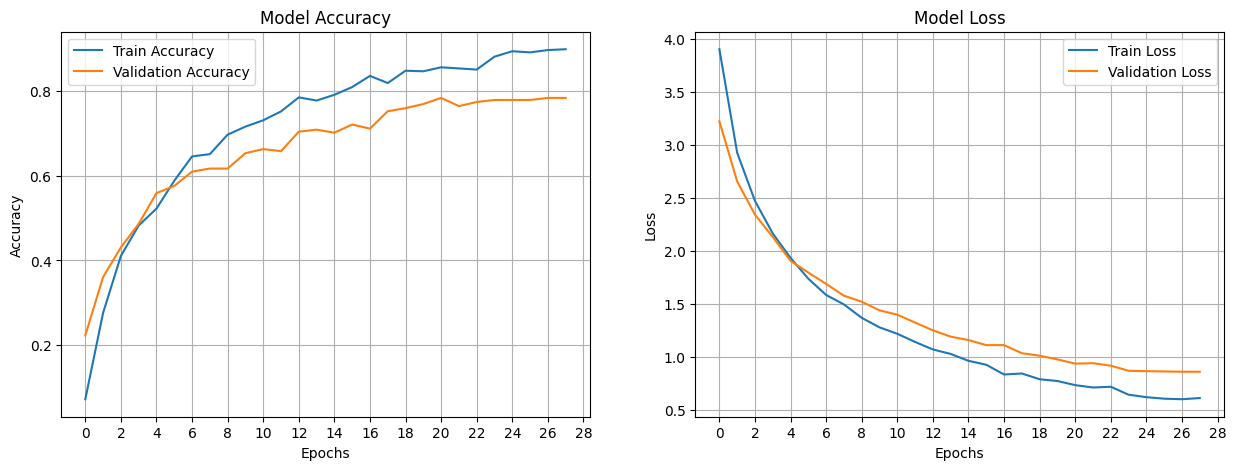

In [25]:
plot_history(h_resnet50)

In [26]:
model_name = 'resnet50_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_m = load_model(model_path)

train_loss, train_accuracy  = resnet50_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.6928037405014038
Training Accuracy: 0.862372875213623
------------------------------------------------
Validation Loss: 0.9375743269920349
Validation Accuracy: 0.7845036387443542
------------------------------------------------
Training Times: 294.9221453666687 seconds


### Prediction of Test Dataset

Predicting Times: 1.2636628150939941 seconds


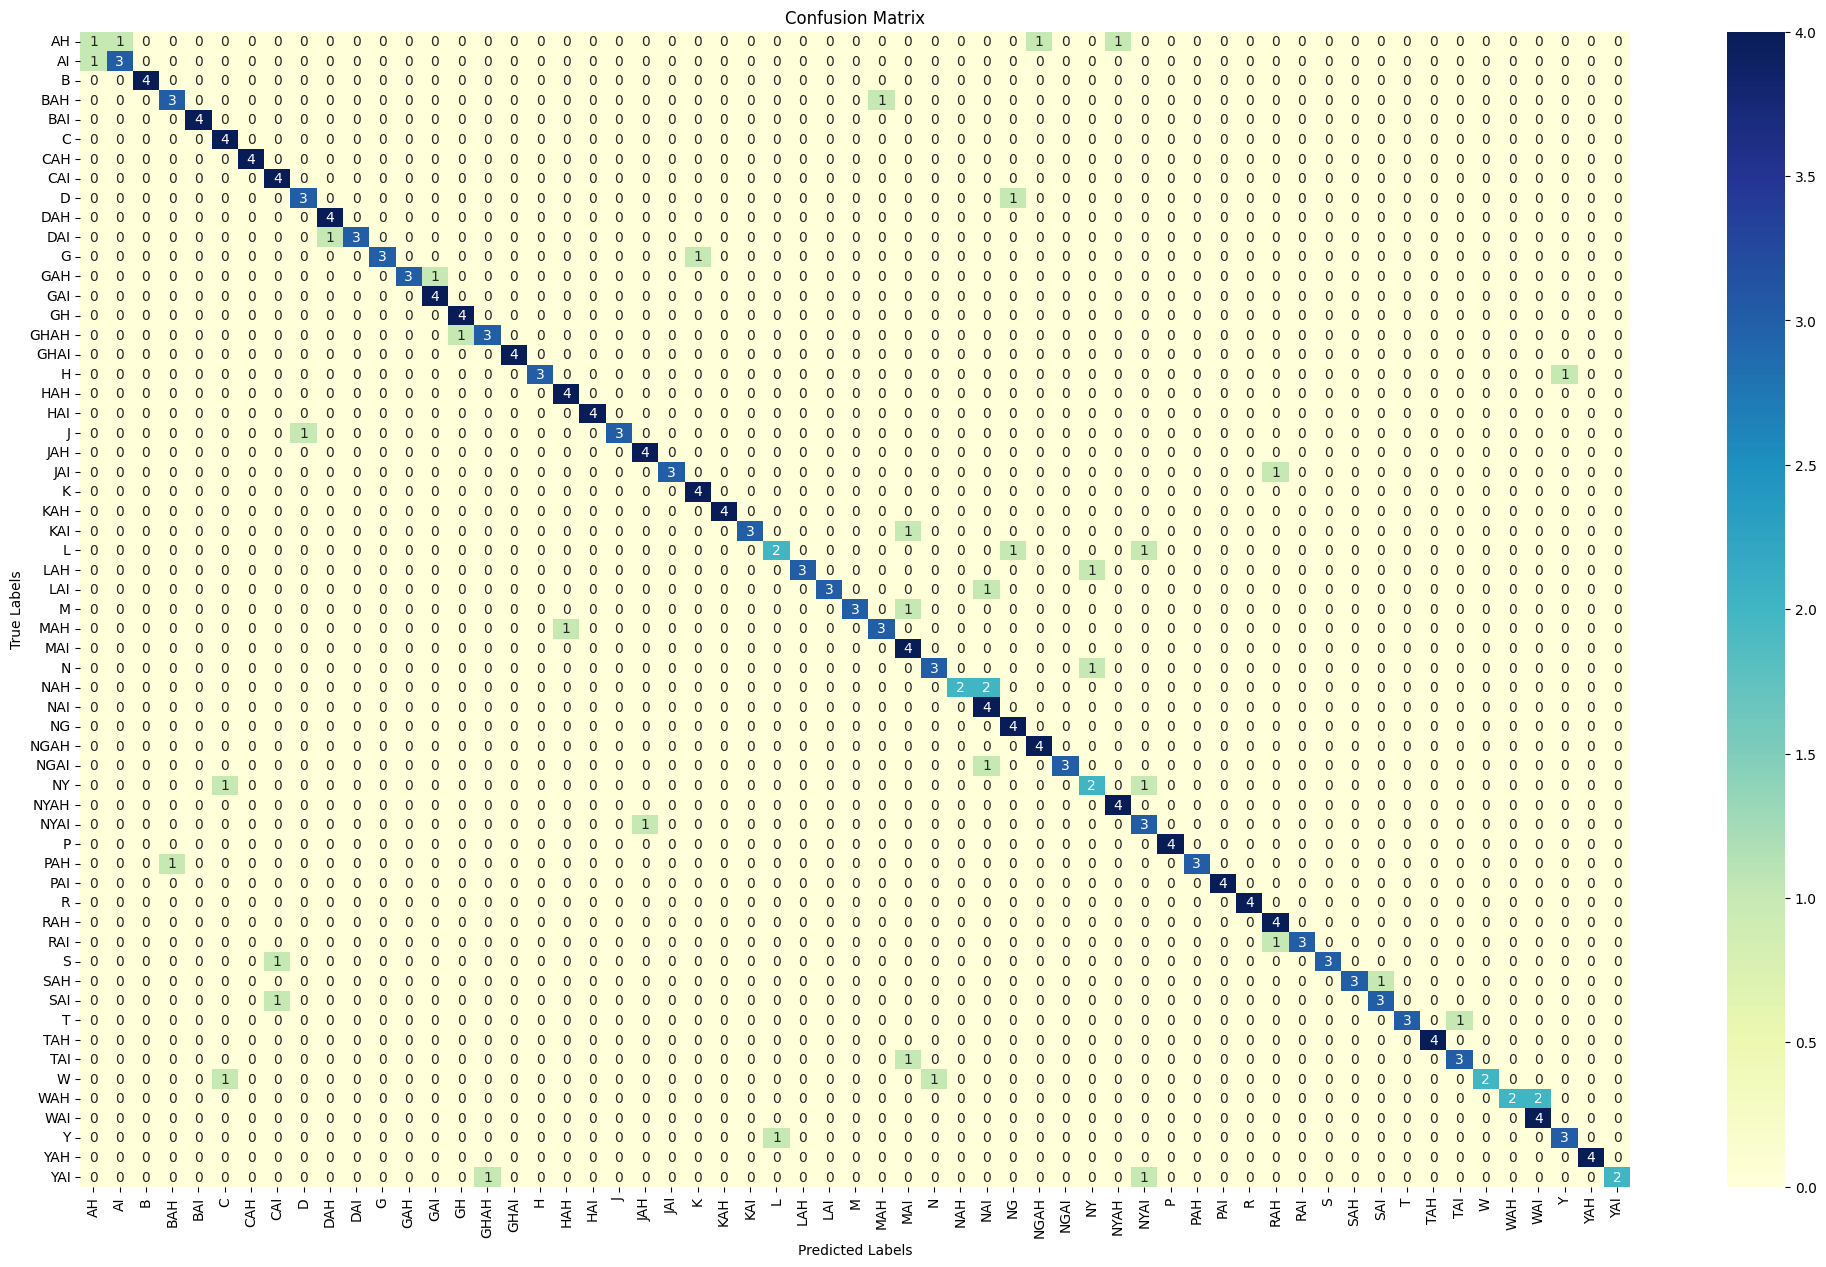

Classification Report:
              precision    recall  f1-score   support

          AH       0.50      0.25      0.33         4
          AI       0.75      0.75      0.75         4
           B       1.00      1.00      1.00         4
         BAH       0.75      0.75      0.75         4
         BAI       1.00      1.00      1.00         4
           C       0.67      1.00      0.80         4
         CAH       1.00      1.00      1.00         4
         CAI       0.67      1.00      0.80         4
           D       0.75      0.75      0.75         4
         DAH       0.80      1.00      0.89         4
         DAI       1.00      0.75      0.86         4
           G       1.00      0.75      0.86         4
         GAH       1.00      0.75      0.86         4
         GAI       0.80      1.00      0.89         4
          GH       0.80      1.00      0.89         4
        GHAH       0.75      0.75      0.75         4
        GHAI       1.00      1.00      1.00         4
    

In [27]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

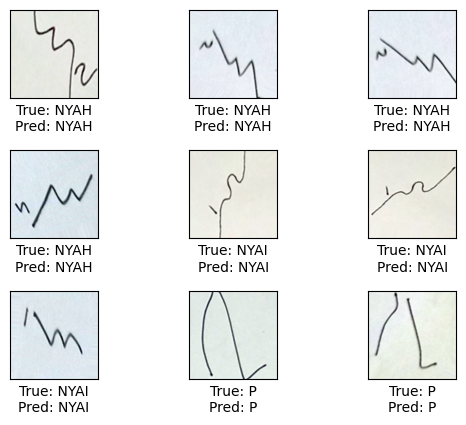

In [28]:
example_success(classes_test, predicted_classes)

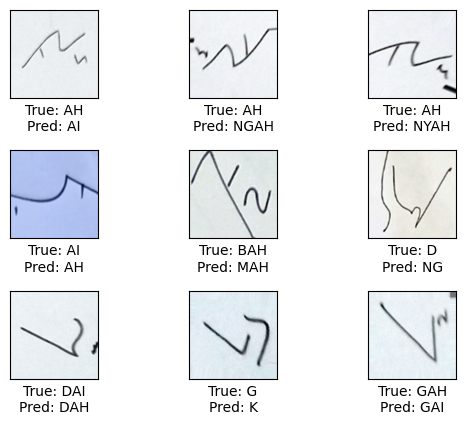

41 41


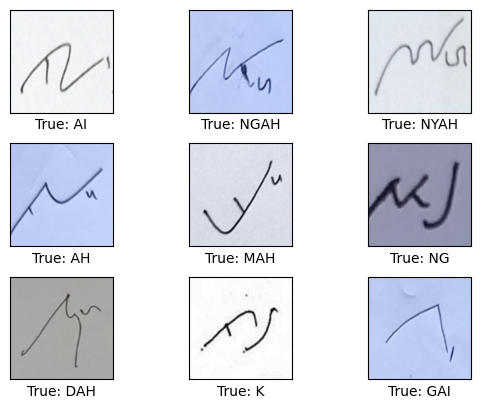

In [ ]:
example_errors(classes_test, predicted_classes)

In [30]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## ResNet50V2 + Random Forest

### Build the Model for Features Extraction

In [32]:
resnet50_pretrained_fe = resnet50_m.layers[-2]

resnet50_pretrained_fe = Model(inputs=resnet50_m.input,
                               outputs=resnet50_pretrained_fe.output)

for layer in resnet50_pretrained_fe.layers:
    layer.trainable = False

resnet50_pretrained_fe.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Hyperparameter Tunning GridSearchCV

In [33]:
X_train = resnet50_pretrained_fe.predict(train_images)
X_val = resnet50_pretrained_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

13/13 [==============================] - 1s 45ms/step


### Training the model

In [34]:
start_time = time.time()
rf_classifier = RandomForestClassifier(random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [35]:
model_name = 'resnet50_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_rf_m = joblib.load(model_path)

In [36]:
# Predictions and evaluation on training set
train_predictions = resnet50_rf_m.predict(X_train)
train_predictions_prob = resnet50_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_rf_m.predict(X_val)
val_predictions_prob = resnet50_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.40211419642693247
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 2.918542462163311
Validation Accuracy: 0.5738498789346247
------------------------------------------------
Training Times: 5.615681886672974 seconds


### Prediction of Test Dataset

8/8 [==============================] - 0s 54ms/step
Predicting Times: 0.575646162033081 seconds


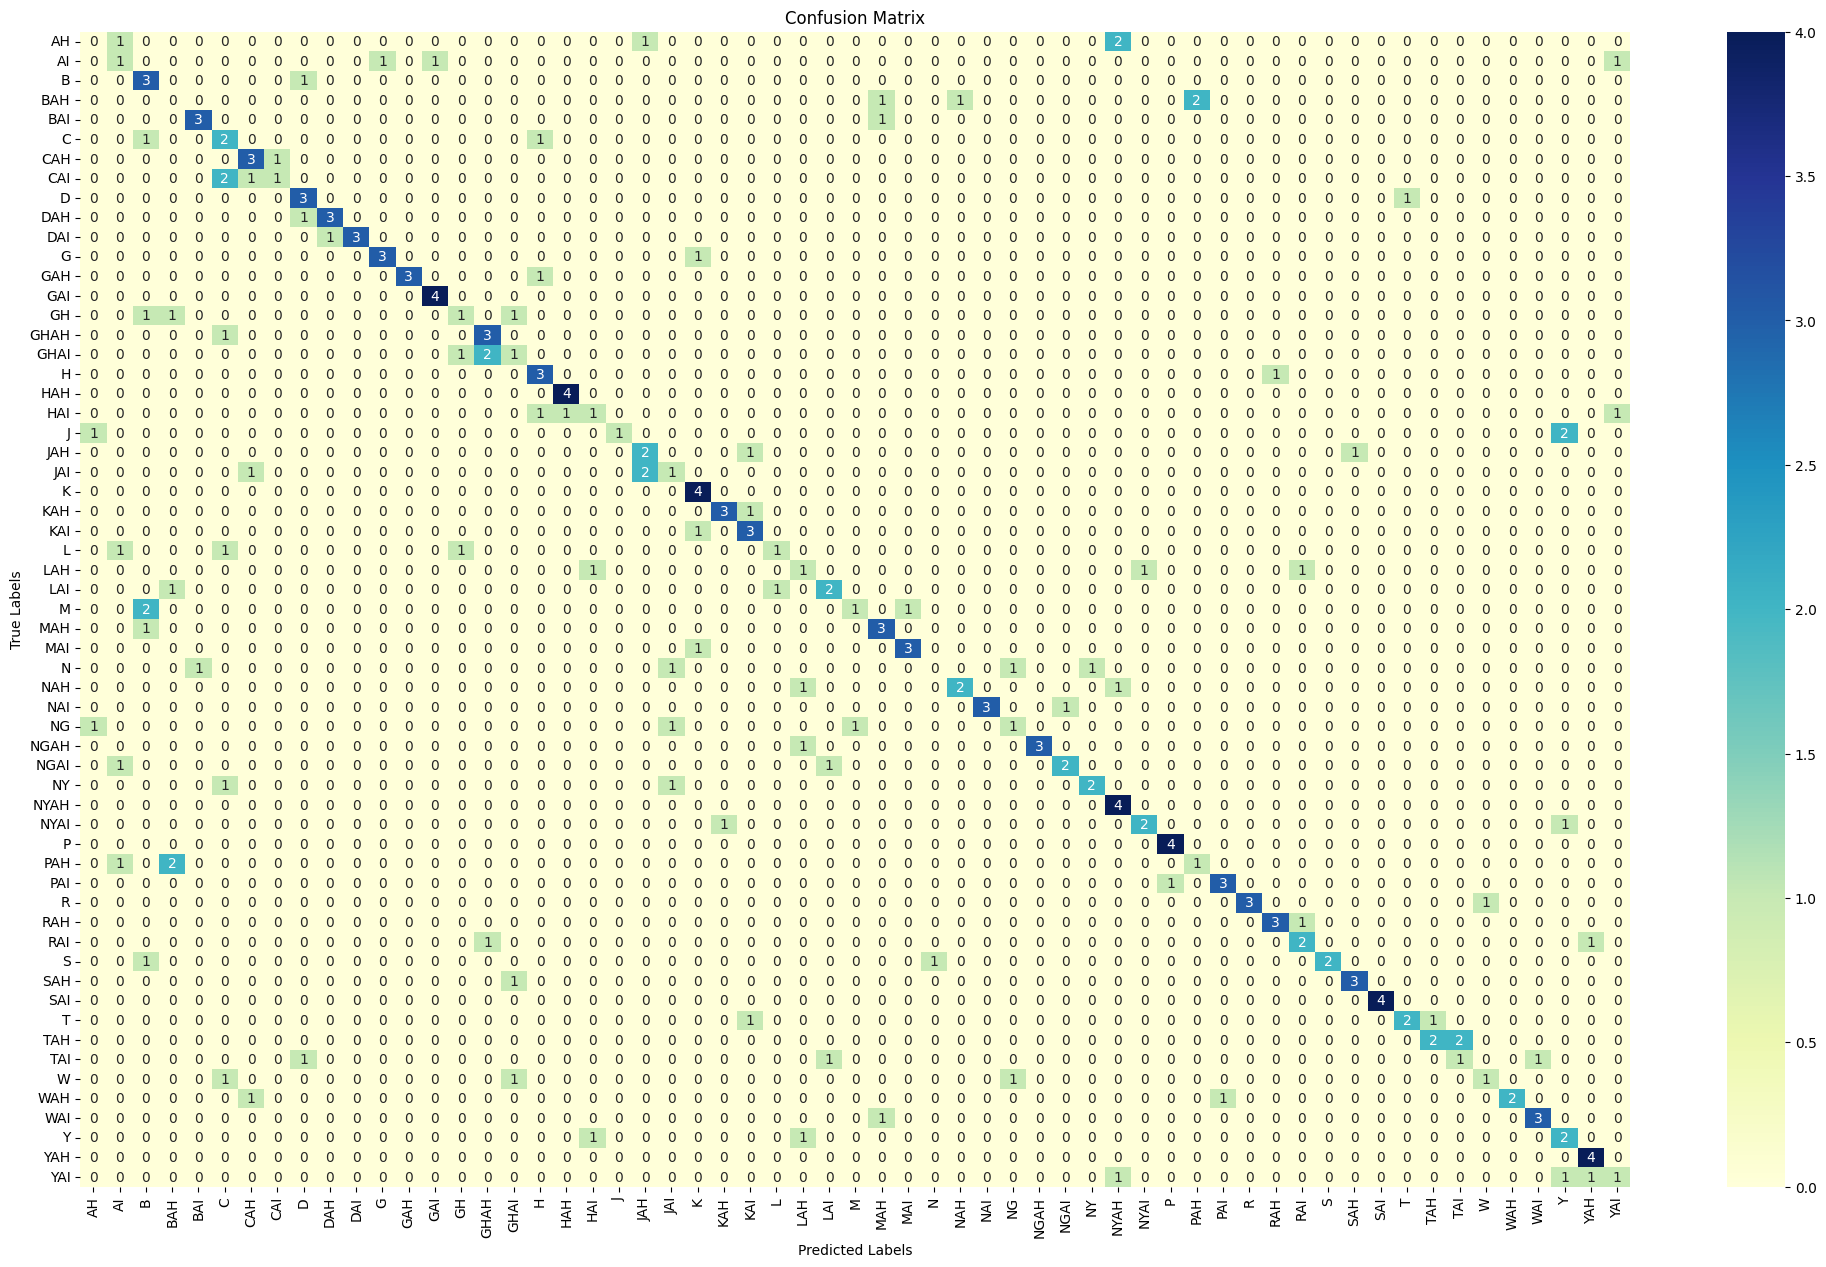

Classification Report:
              precision    recall  f1-score   support

          AH       0.00      0.00      0.00         4
          AI       0.20      0.25      0.22         4
           B       0.33      0.75      0.46         4
         BAH       0.00      0.00      0.00         4
         BAI       0.75      0.75      0.75         4
           C       0.25      0.50      0.33         4
         CAH       0.50      0.75      0.60         4
         CAI       0.50      0.25      0.33         4
           D       0.50      0.75      0.60         4
         DAH       0.75      0.75      0.75         4
         DAI       1.00      0.75      0.86         4
           G       0.75      0.75      0.75         4
         GAH       1.00      0.75      0.86         4
         GAI       0.80      1.00      0.89         4
          GH       0.33      0.25      0.29         4
        GHAH       0.50      0.75      0.60         4
        GHAI       0.25      0.25      0.25         4
    

In [37]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_pretrained_fe.predict(test_images)
predictions = resnet50_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

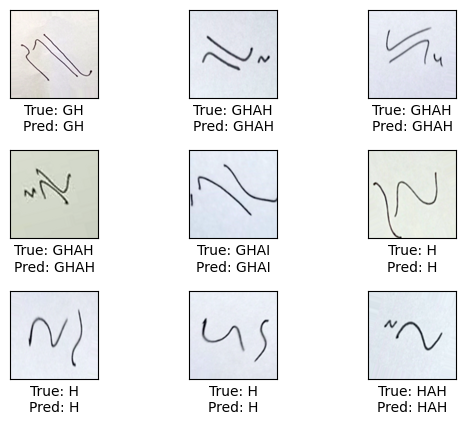

In [38]:
example_success(y_test, predictions)

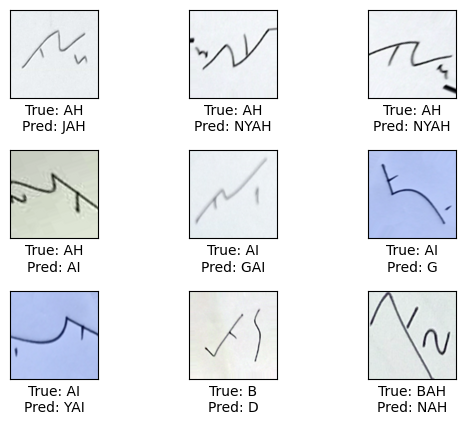

103 103


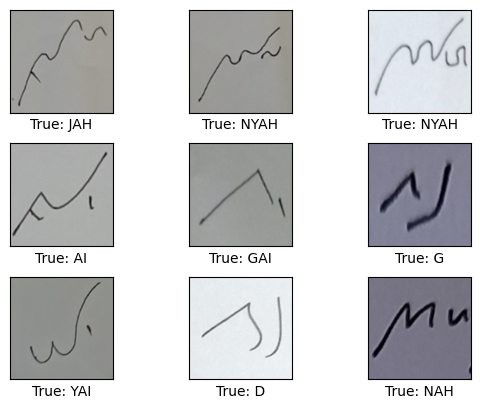

In [ ]:
example_errors(y_test, predictions)

In [40]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## ResNet50V2 Tuning

### Build the Model

In [41]:
m = resnet50_pretrained.output
m = GlobalAveragePooling2D()(m)
m = BatchNormalization()(m)
m = Dense(512, activation='relu', name='fc1')(m)
m = Dropout(0.5)(m)
predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

resnet50_tuned_m = Model(inputs=resnet50_pretrained.input, outputs=predictions, name="resnet50_tuned")

resnet50_tuned_m.summary()

Model: "resnet50_tuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [42]:
for layer in resnet50_tuned_m.layers:
    layer.trainable = True

print_layer_trainable(resnet50_tuned_m)

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [43]:
for layer in resnet50_tuned_m.layers:
    if layer.name.startswith('conv5_'):
        break
    layer.trainable = False

resnet50_tuned_m.summary()

Model: "resnet50_tuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [44]:
print_layer_trainable(resnet50_tuned_m)

False:	input_1
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [45]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_tuned_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [46]:
resnet50_tuned_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50_tune = resnet50_tuned_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
46/46 [==============================] - 13s 234ms/step - loss: 4.0755 - categorical_accuracy: 0.1003 - val_loss: 6.3031 - val_categorical_accuracy: 0.0460 - lr: 0.0010
Epoch 2/30
46/46 [==============================] - 10s 209ms/step - loss: 2.4148 - categorical_accuracy: 0.3539 - val_loss: 3.6672 - val_categorical_accuracy: 0.1574 - lr: 0.0010
Epoch 3/30
46/46 [==============================] - 10s 212ms/step - loss: 1.5693 - categorical_accuracy: 0.5539 - val_loss: 2.3674 - val_categorical_accuracy: 0.3414 - lr: 0.0010
Epoch 4/30
46/46 [==============================] - 9s 201ms/step - loss: 1.1989 - categorical_accuracy: 0.6495 - val_loss: 4.3501 - val_categorical_accuracy: 0.1792 - lr: 0.0010
Epoch 5/30
46/46 [==============================] - 10s 214ms/step - loss: 0.8701 - categorical_accuracy: 0.7363 - val_loss: 1.3272 - val_categorical_accuracy: 0.6441 - lr: 0.0010
Epoch 6/30
46/46 [==============================] - 10s 212ms/step - loss: 0.8796 - categorical_accur

### Model Evaluation

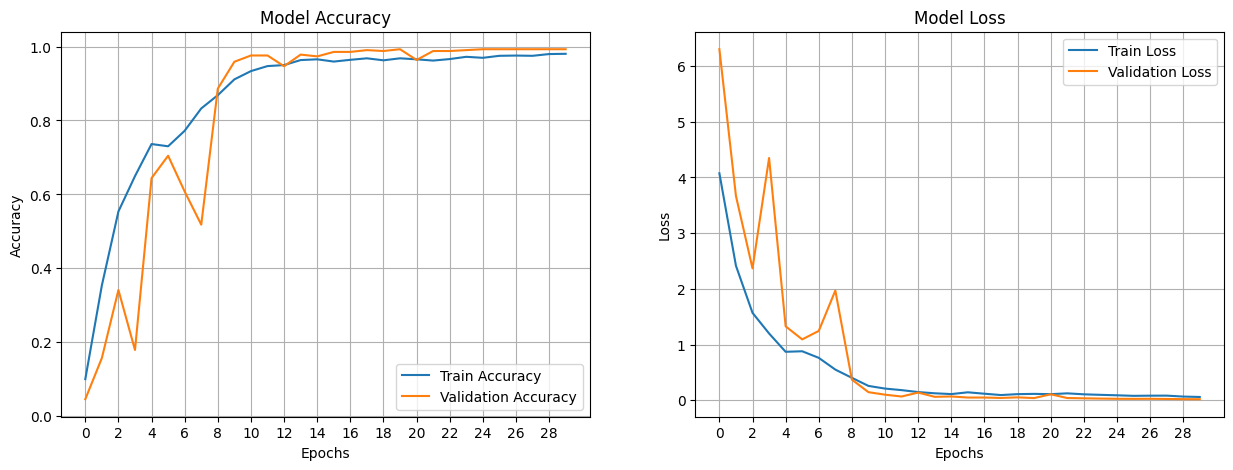

In [47]:
plot_history(h_resnet50_tune)

In [48]:
model_name = 'resnet50_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_tuned_m = load_model(model_path)

train_loss, train_accuracy = resnet50_tuned_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_tuned_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.012879665940999985
Training Accuracy: 0.9972881078720093
------------------------------------------------
Validation Loss: 0.038997262716293335
Validation Accuracy: 0.9927361011505127
------------------------------------------------
Training Times: 302.65801644325256 seconds


### Prediction of Test Dataset

Predicting Times: 1.0486586093902588 seconds


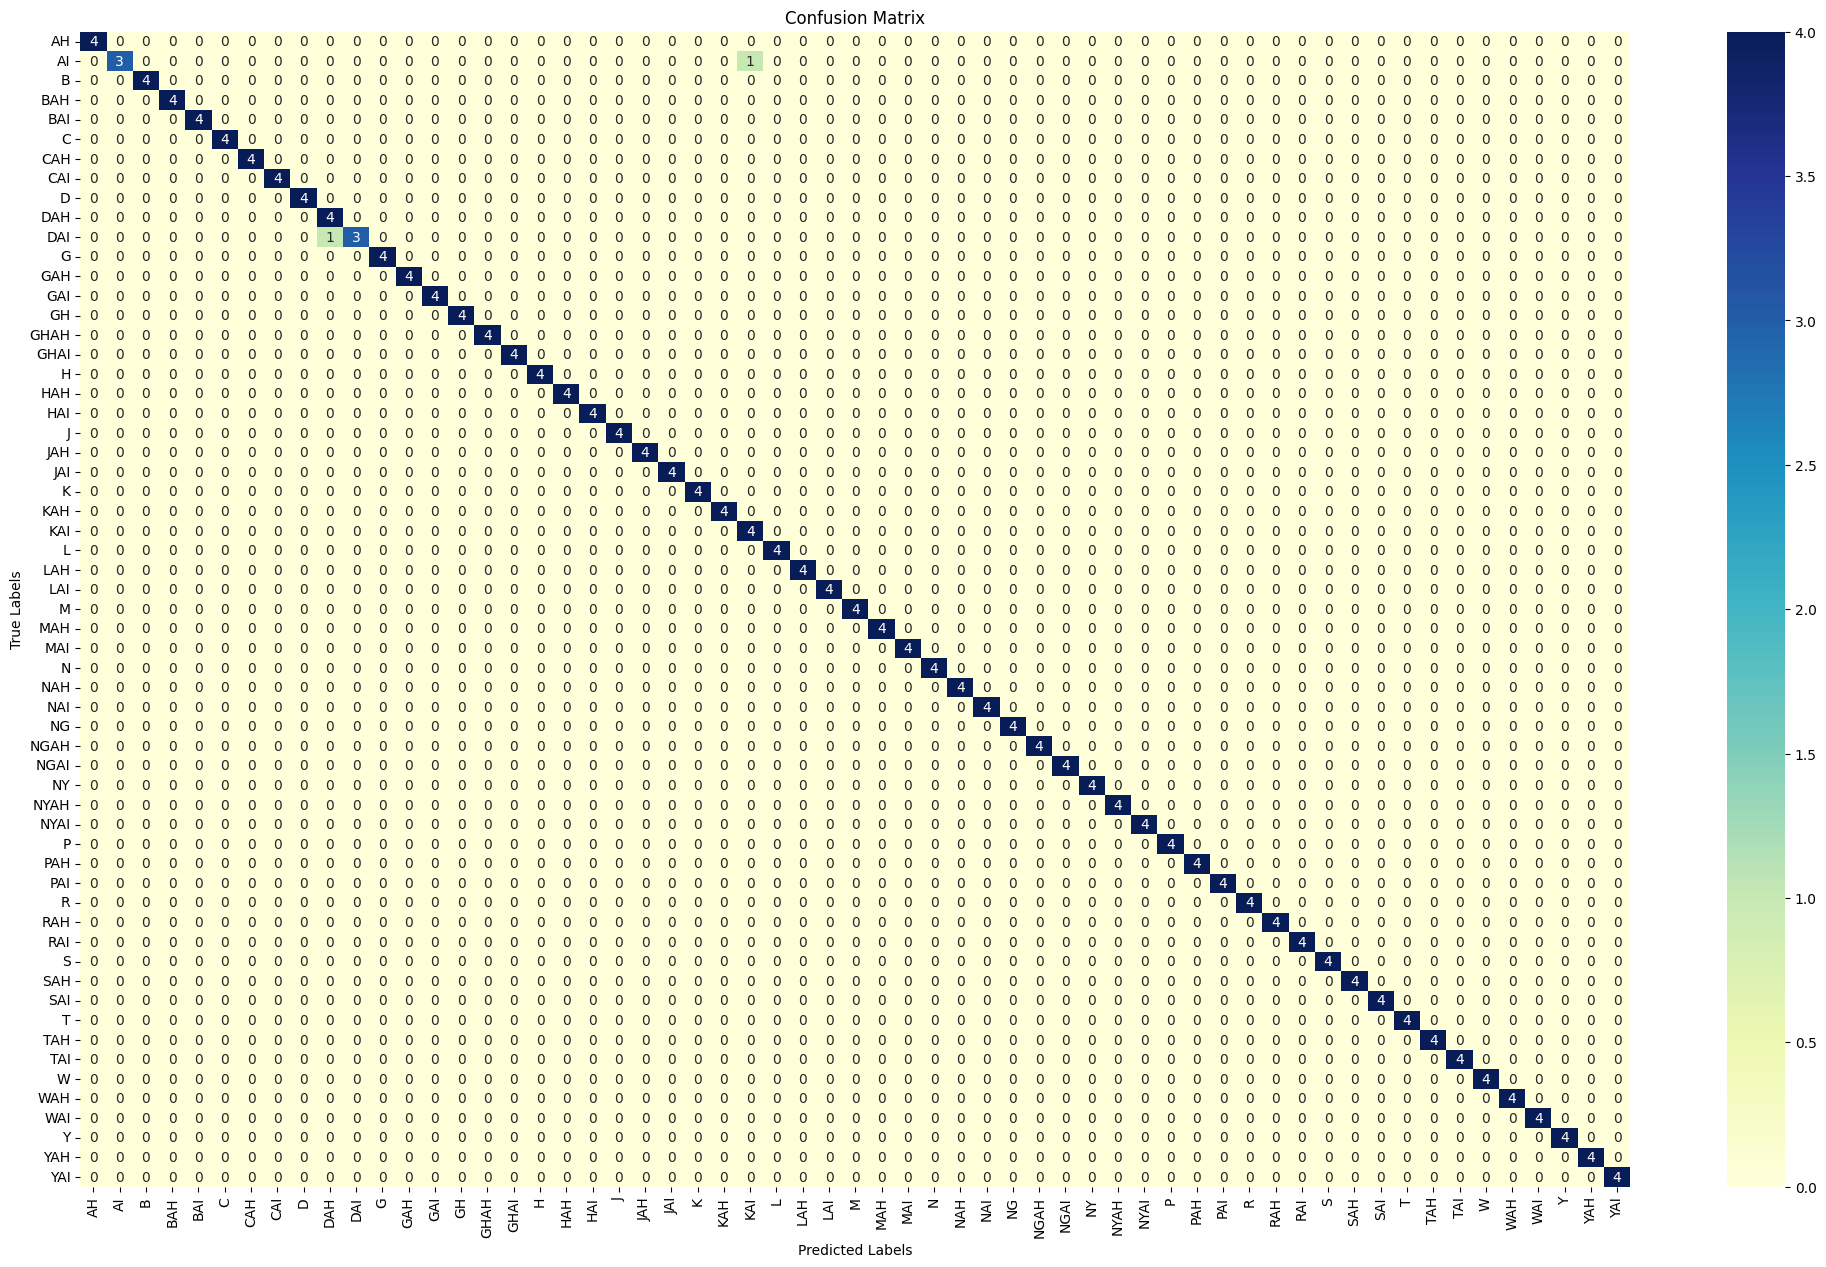

Classification Report:
              precision    recall  f1-score   support

          AH       1.00      1.00      1.00         4
          AI       1.00      0.75      0.86         4
           B       1.00      1.00      1.00         4
         BAH       1.00      1.00      1.00         4
         BAI       1.00      1.00      1.00         4
           C       1.00      1.00      1.00         4
         CAH       1.00      1.00      1.00         4
         CAI       1.00      1.00      1.00         4
           D       1.00      1.00      1.00         4
         DAH       0.80      1.00      0.89         4
         DAI       1.00      0.75      0.86         4
           G       1.00      1.00      1.00         4
         GAH       1.00      1.00      1.00         4
         GAI       1.00      1.00      1.00         4
          GH       1.00      1.00      1.00         4
        GHAH       1.00      1.00      1.00         4
        GHAI       1.00      1.00      1.00         4
    

In [49]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_tuned_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_tuned_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

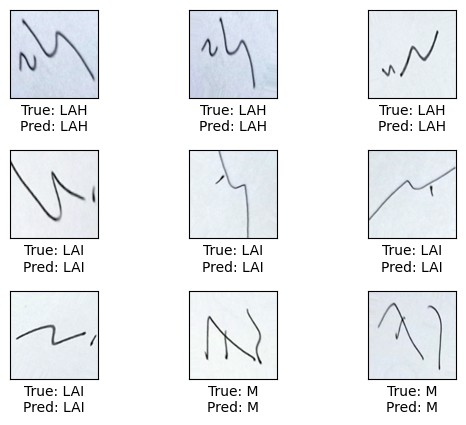

In [50]:
example_success(classes_test, predicted_classes)

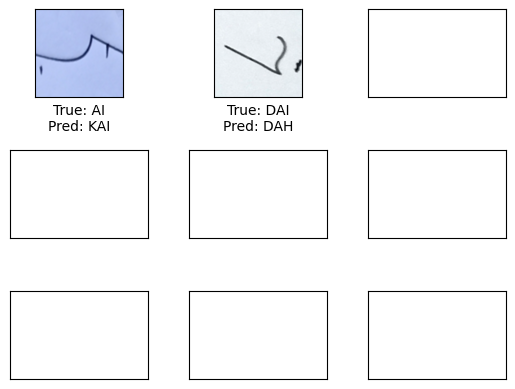

2 2


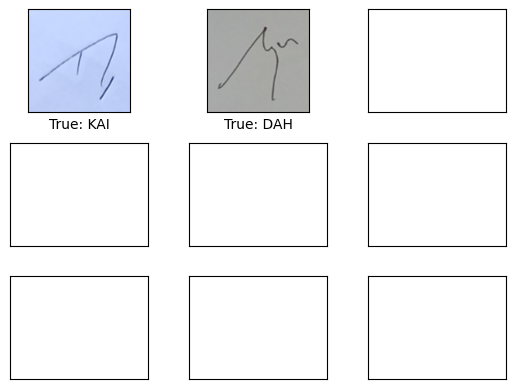

In [ ]:
example_errors(classes_test, predicted_classes)

In [52]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


## ResNet50V2 + Random Forest Tuning

### Build the Model for Features Extraction

In [53]:
resnet50_ft_fe = resnet50_tuned_m.layers[-5]

resnet50_ft_fe = Model(inputs=resnet50_tuned_m.input,
                  outputs=resnet50_ft_fe.output)

for layer in resnet50_ft_fe.layers:
    layer.trainable = False

resnet50_ft_fe.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Hyperparameter Tunning GridSearchCV

In [54]:
X_train = resnet50_ft_fe.predict(train_images)
X_val = resnet50_ft_fe.predict(val_images)
y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

13/13 [==============================] - 1s 45ms/step


In [55]:
params = {
    'n_estimators' : [100, 200, 300, 400],
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400]},
             refit='accuracy', scoring=['accuracy', 'neg_log_loss'])

In [56]:
grid_search_results(gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.963) log_loss: (test=0.987)
[CV 2/5] accuracy: (test=0.942) log_loss: (test=1.015)
[CV 3/5] accuracy: (test=0.950) log_loss: (test=0.968)
[CV 4/5] accuracy: (test=0.979) log_loss: (test=0.786)
[CV 5/5] accuracy: (test=0.976) log_loss: (test=0.905)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.981) log_loss: (test=0.968)
[CV 2/5] accuracy: (test=0.947) log_loss: (test=1.012)
[CV 3/5] accuracy: (test=0.963) log_loss: (test=0.958)
[CV 4/5] accuracy: (test=0.987) log_loss: (test=0.790)
[CV 5/5] accuracy: (test=0.976) log_loss: (test=0.903)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.984) log_loss: (test=0.965)
[CV 2/5] accuracy: (test=0.947) log_loss: (test=1.008)
[CV 3/5] accuracy: (test=0.966) log_loss: (test=0.955)
[CV 4/5] accuracy: (test=0.987) log_loss: (test=0.791)
[CV 5/5] accuracy: (test=0.987) log_loss: (test=0.902)

Parameters

### Training the model

In [57]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [58]:
model_name = 'resnet50_rf_tuned_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_rf_tuned_m = joblib.load(model_path)

In [59]:
# Predictions and evaluation on training set
train_predictions = resnet50_rf_tuned_m.predict(X_train)
train_predictions_prob = resnet50_rf_tuned_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_rf_tuned_m.predict(X_val)
val_predictions_prob = resnet50_rf_tuned_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.23109001150579003
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.920990989792333
Validation Accuracy: 0.9830508474576272
------------------------------------------------
Training Times: 20.65951371192932 seconds


### Prediction of Test Dataset

8/8 [==============================] - 0s 61ms/step
Predicting Times: 0.5934715270996094 seconds


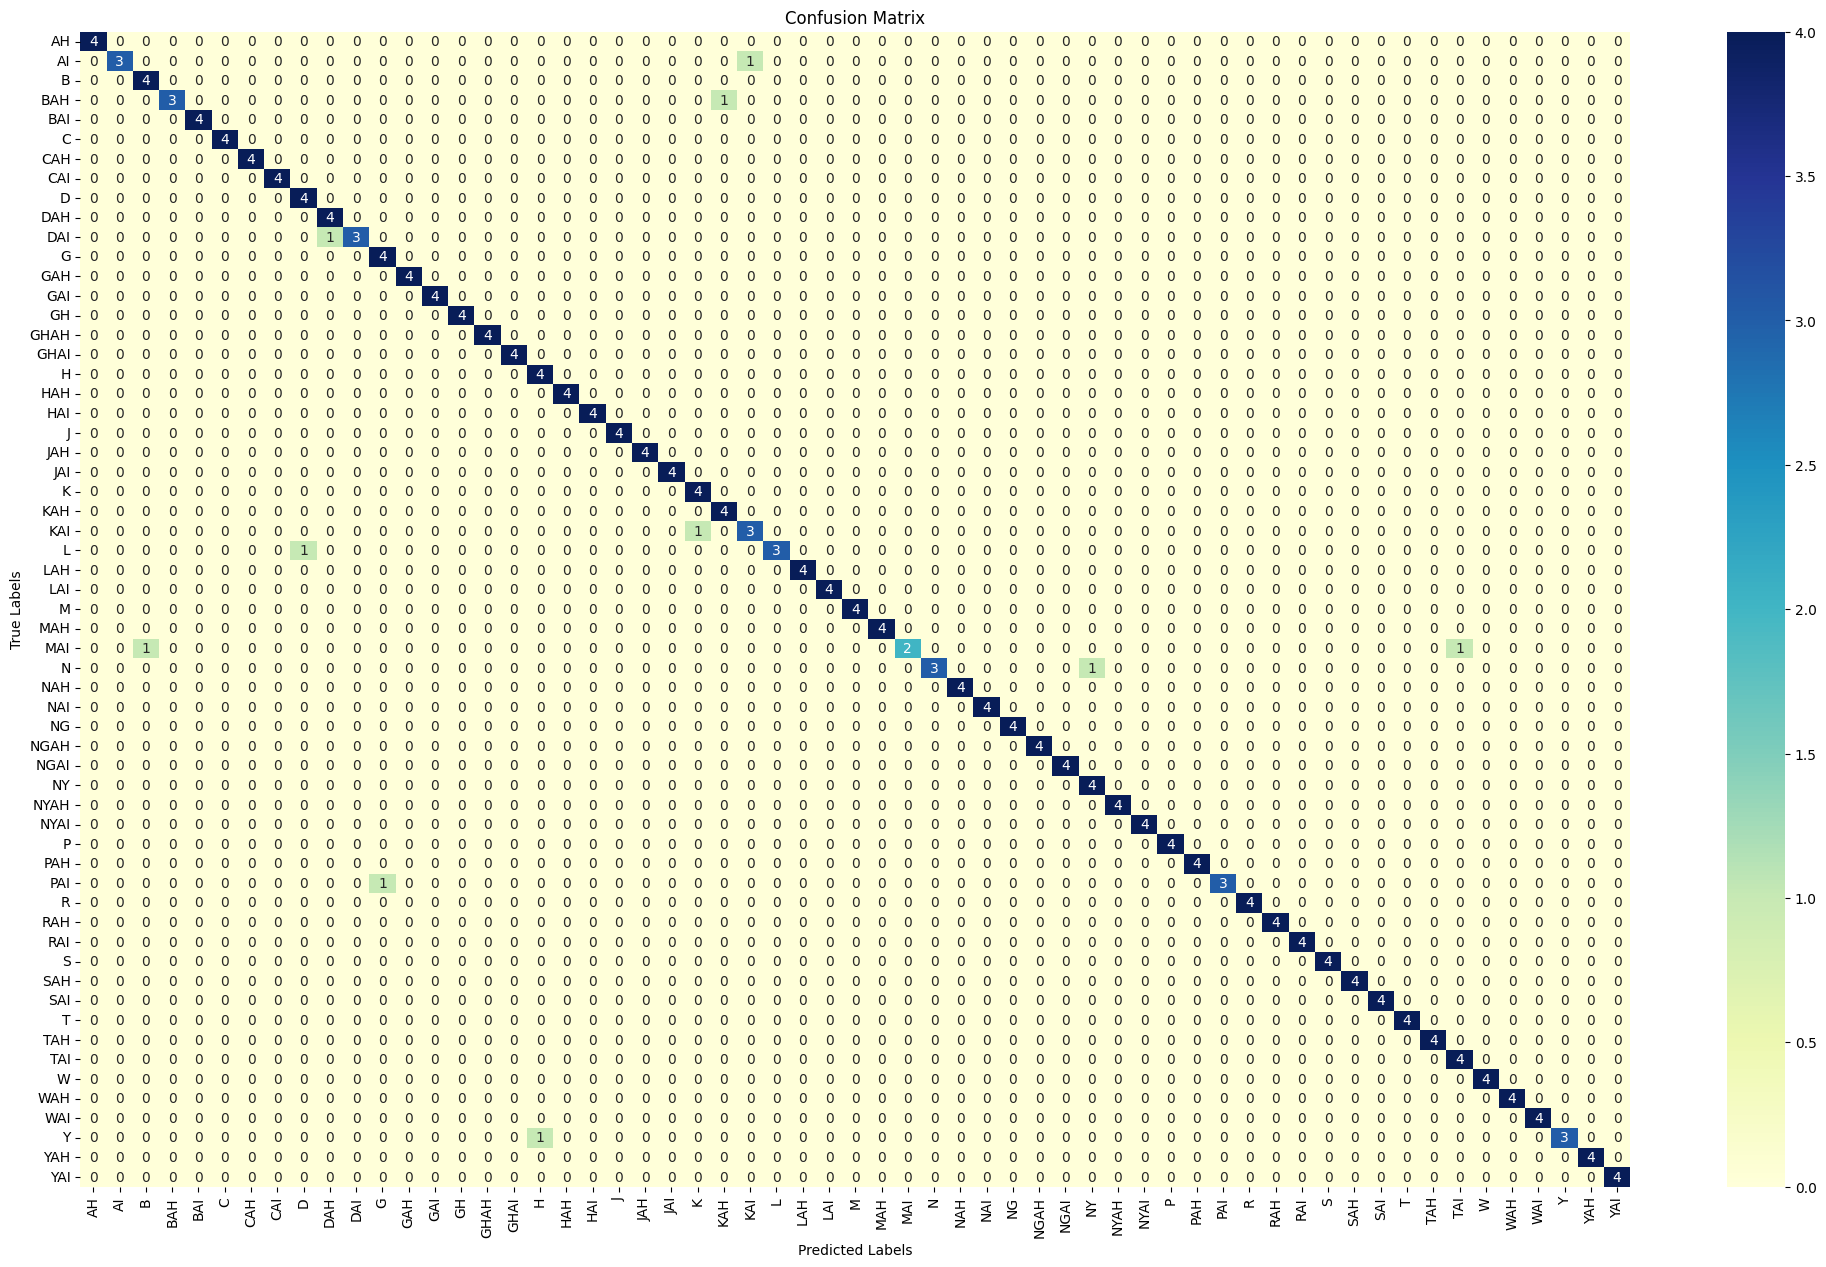

Classification Report:
              precision    recall  f1-score   support

          AH       1.00      1.00      1.00         4
          AI       1.00      0.75      0.86         4
           B       0.80      1.00      0.89         4
         BAH       1.00      0.75      0.86         4
         BAI       1.00      1.00      1.00         4
           C       1.00      1.00      1.00         4
         CAH       1.00      1.00      1.00         4
         CAI       1.00      1.00      1.00         4
           D       0.80      1.00      0.89         4
         DAH       0.80      1.00      0.89         4
         DAI       1.00      0.75      0.86         4
           G       0.80      1.00      0.89         4
         GAH       1.00      1.00      1.00         4
         GAI       1.00      1.00      1.00         4
          GH       1.00      1.00      1.00         4
        GHAH       1.00      1.00      1.00         4
        GHAI       1.00      1.00      1.00         4
    

In [60]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_ft_fe.predict(test_images)
predictions = resnet50_rf_tuned_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

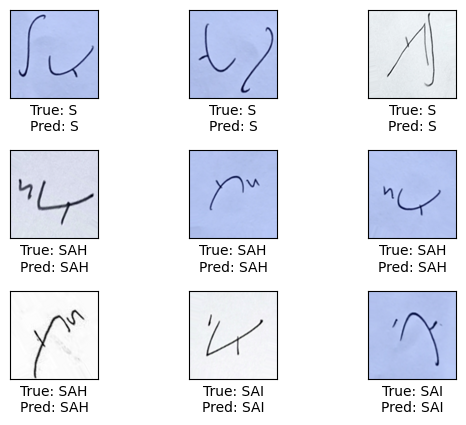

In [61]:
example_success(y_test, predictions)

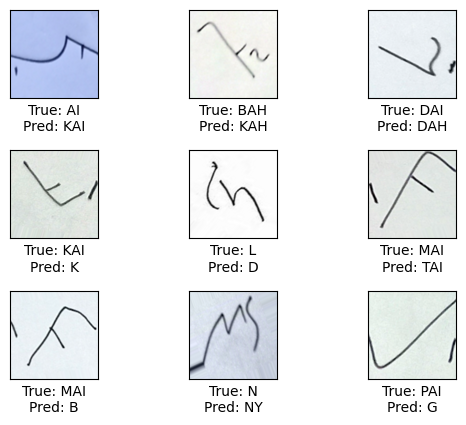

10 10


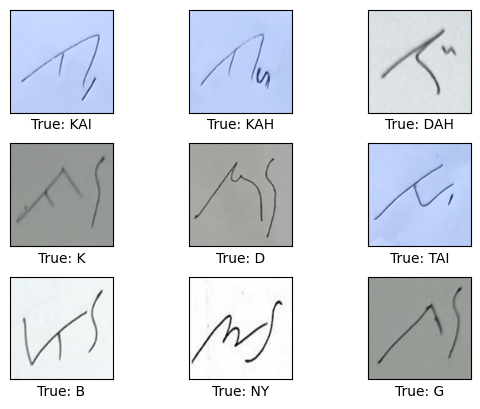

In [ ]:
example_errors(y_test, predictions)

In [63]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]
save_results(accuracy_results)

Data has been saved to ../benchmark_result/Induk anak huruf di samping/results.csv


# Benchmark All Models

In [27]:
df = pd.read_csv(csv_file, delimiter=';')
df.round(4)

Model Name  Train Accuracy  Validation Accuracy  Test Accuracy  \
0              vgg16_m          0.9383               0.8886         0.9195   
1           vgg16_rf_m          1.0000               0.5085         0.5254   
2        vgg16_tuned_m          0.9498               0.9274         0.9364   
3     vgg16_rf_tuned_m          1.0000               0.9516         0.9492   
4           resnet50_m          0.8624               0.7845         0.8263   
5        resnet50_rf_m          1.0000               0.5738         0.5593   
6     resnet50_tuned_m          0.9973               0.9927         0.9915   
7  resnet50_rf_tuned_m          1.0000               0.9831         0.9576   

   Training Time  Predicting Time  
0       387.0266           2.8926  
1        20.2773           2.9918  
2       318.7522           2.8339  
3         5.0411           0.8594  
4       294.9221           1.2637  
5         5.6157           0.5756  
6       302.6580           1.0487  
7        20.6595           0.5935